# Mei's TRAPseq Analysis

##### Tommy Tang

In [ ]:
#Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator, MultipleLocator
from PIL import Image
import re
import io
from typing import Union
from scipy.stats import chi2_contingency, chi2
import itertools

## Task 1: Proprocessing and Exploration 

In [3]:
#Read the Excel file, getting the first sheet
df0 = pd.read_excel('Data/D819_IP_vs_L450_IP_TRAP_simplified.xlsx', sheet_name=0)
df1 = pd.read_excel('Data/D819_IP_vs_L450_IP_TRAP_simplified.xlsx', sheet_name=1)
df2 = pd.read_excel('Data/transcription factors.xls', sheet_name=0, skiprows=2)
df3 = pd.read_excel('Data/D150_IP vs. L3_IP_TRAP_simplified_2 (3).xlsx', sheet_name=0)

In [4]:
#Inner join the two dataframes on the 'Gene' column
df = pd.merge(df0, df1, on='Name', how='inner')
df = pd.merge(df, df3, on='Name', how='inner')

In [5]:
#Data exploration
df.info()
df.describe()
#df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31555 entries, 0 to 31554
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       31555 non-null  object 
 1   L450 TPM   31555 non-null  float64
 2   L450 RPKM  31555 non-null  float64
 3   D819 TPM   31555 non-null  float64
 4   D819 RPKM  31555 non-null  float64
 5   L300 TPM   31555 non-null  float64
 6   L300 RPKM  31555 non-null  float64
 7   D150 TPM   31555 non-null  float64
 8   L150 RPKM  31555 non-null  float64
dtypes: float64(8), object(1)
memory usage: 2.2+ MB


,L450 TPM,L450 RPKM,D819 TPM,D819 RPKM,L300 TPM,L300 RPKM,D150 TPM,L150 RPKM
count,31555.000000,31555.000000,31555.000000,31555.000000,31555.000000,31555.000000,31555.000000,31555.000000
mean,31.689809,26.375235,31.690166,27.157600,31.690385,28.288026,31.690230,27.318301
std,242.145431,201.536168,410.820221,352.061625,192.620361,171.940159,593.907933,511.973423
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.572188,0.476228,0.362751,0.310868,0.505582,0.451301,0.521814,0.449826
75%,11.925846,9.925809,9.267425,7.941928,12.086384,10.788760,8.576161,7.393009
max,13422.588013,11171.538280,31536.231209,27025.682385,8629.172307,7702.722841,62697.346442,54047.729035


In [6]:
#Get column names (usually not exactly the same as in the excel)
features = df.columns.tolist()
features

['Name',
 'L450 TPM',
 'L450 RPKM',
 'D819 TPM',
 'D819 RPKM',
 'L300 TPM',
 'L300 RPKM',
 'D150 TPM',
 'L150 RPKM']

In [7]:
#Remove rows without gene names
df = df[df['Name'].notna()]

#### Data Filtering (Remove Genes)

In [8]:
#Filter out genes if transcripts per million (TPM) < 10 for both L450 and dauer and save to a new Excel file
#If TPM for either L450 or dauer is less than 10, the gene is not filtered, only if both are less than 10
df_filtered_tpm = df[(df['L450 TPM'] >= 10) | (df['D819 TPM'] >= 10)]
df_filtered_tpm.to_excel('Data/D819 vs L450/D819_IP vs. L450_IP_TRAP_simplified filtered by TPM.xlsx', index=False)

#Filter out genes if TPM = 0 for either L450 or dauer
df_zero_filtered_tpm = df[(df['L450 TPM'] > 0) & (df['D819 TPM'] > 0) & (df['L300 TPM'] > 0) & (df['D150 TPM'] > 0)]

In [9]:
#Filter out genes if transcripts per million (RPKM) < 10 for both L450 and dauer and save to a new Excel file
#If RPKM for either L450 or dauer is less than 10, the gene is not filtered, only if both are less than 10
df_filtered_rpkm = df[(df['L450 RPKM'] >= 10) | (df['D819 RPKM'] >= 10)]
df_filtered_rpkm.to_excel('Data/D819 vs L450/D819_IP vs. L450_IP_TRAP_simplified filtered by RPKM.xlsx', index=False)

#Filter out genes if RPKM = 0 for either L450 or dauer
df_zero_filtered_rpkm = df[(df['L450 RPKM'] > 0) & (df['D819 RPKM'] > 0)]

In [10]:
#See filtered results
print("TPM FILTERED RESULTS -----------------------------")
print(f'Before: {df.shape[0]} genes -> After: {df_filtered_tpm.shape[0]} genes')
print(df_filtered_tpm.info())
print(df_filtered_tpm.describe())

print("\nRPKM FILTERED RESULTS -----------------------------")
print(f'Before: {df.shape[0]} genes -> After: {df_filtered_rpkm.shape[0]} genes')
print(df_filtered_rpkm.info())
print(df_filtered_rpkm.describe())

TPM FILTERED RESULTS -----------------------------
Before: 31555 genes -> After: 9542 genes
<class 'pandas.core.frame.DataFrame'>
Index: 9542 entries, 1 to 31554
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       9542 non-null   object 
 1   L450 TPM   9542 non-null   float64
 2   L450 RPKM  9542 non-null   float64
 3   D819 TPM   9542 non-null   float64
 4   D819 RPKM  9542 non-null   float64
 5   L300 TPM   9542 non-null   float64
 6   L300 RPKM  9542 non-null   float64
 7   D150 TPM   9542 non-null   float64
 8   L150 RPKM  9542 non-null   float64
dtypes: float64(8), object(1)
memory usage: 745.5+ KB
None
           L450 TPM     L450 RPKM      D819 TPM     D819 RPKM     L300 TPM  \
count   9542.000000   9542.000000   9542.000000   9542.000000  9542.000000   
mean     102.402669     85.229118    102.858524     88.146925    98.979362   
std      432.130993    359.659995    742.225192    636.066566   340.53300

#### Neuropeptide and Related Genes

In [11]:
#From Wormbase.org @ https://www.ncbi.nlm.nih.gov/books/NBK154158/table/neuronalgenome_table15/?report=objectonly
#Also added some additional enzymes and TGF-beta genes from Mei at the end of the list
neuropeptide_genes = [
    "flp-1", "flp-2", "flp-3", "flp-4", "flp-5", "flp-6", "flp-7", "flp-8", "flp-9", "flp-10", "flp-11", "flp-12", "flp-13", "flp-14", "flp-15", "flp-16", 
    "flp-17", "flp-18", "flp-19", "flp-20", "flp-21", "flp-22", "flp-23", "flp-24", "flp-25", "flp-26", "flp-27", "flp-28", "flp-32", "flp-33",  
    "flp-44", "nlp-1", "nlp-2", "nlp-3", "nlp-4", "nlp-5", "nlp-6", "nlp-7", "nlp-8", "nlp-9", "nlp-10", "nlp-11", "nlp-12", "nlp-13", "nlp-14", "nlp-15",
    "nlp-16", "nlp-17", "nlp-18", "nlp-19", "nlp-20", "nlp-21", "nlp-22", "nlp-23", "nlp-24", "nlp-25", "nlp-26", "nlp-27", "nlp-28", "nlp-29", "nlp-30",
    "nlp-31", "nlp-32", "nlp-33", "nlp-34", "nlp-35", "nlp-36", "nlp-37", "nlp-38", "nlp-39", "nlp-40", "nlp-41", "nlp-42", "nlp-43", "nlp-44", "nlp-45",
    "nlp-46", "nlp-47", "nlp-48", "daf-28", "ins-1", "ins-2", "ins-3", "ins-4", "ins-5", "ins-6", "ins-7", "ins-8", "ins-9", "ins-10", "ins-11", "ins-12", 
    "ins-13", "ins-14", "ins-15", "ins-16", "ins-17", "ins-18", "ins-19", "ins-20", "ins-21", "ins-22", "ins-23", "ins-24", "ins-25", "ins-26", "ins-27",
    "ins-28", "ins-29", "ins-30", "ins-31", "ins-32", "ins-33", "ins-34", "ins-35", "ins-36", "ins-37", "ins-38", "ins-39", "pdf-1", "snet-1", "ntc-1", 
    "daf-7", "egl-3", "elg-21", "sbt-1"
]

print(f'Total number of ion channel genes: {len(neuropeptide_genes)}')
print(f'Total number of unique ion channel genes: {len(set(neuropeptide_genes))}')

Total number of ion channel genes: 126
Total number of unique ion channel genes: 126


In [12]:
#Get dataframes filtered by neuropeptide genes
df_neuropep = df[df['Name'].isin(neuropeptide_genes)]
df_zero_filtered_neuropep = df_zero_filtered_tpm[df_zero_filtered_tpm['Name'].isin(neuropeptide_genes)]
df_filtered_tpm_neuropep = df_filtered_tpm[df_filtered_tpm['Name'].isin(neuropeptide_genes)]
df_filtered_rpkm_neuropep = df_filtered_rpkm[df_filtered_rpkm['Name'].isin(neuropeptide_genes)]

print("NEUROPEPTIDE UNFILTERED RESULTS -----------------------------")
print(f'Number of neuropeptide and related genes found in unfiltered dataset: {df_neuropep.shape[0]}\n')
print("NEUROPEPTIDE ZERO FILTERED RESULTS -----------------------------")
print(f'Number of neuropeptide and related genes found in zero filtered dataset: {df_zero_filtered_neuropep.shape[0]}\n')
print("TPM NEUROPEPTIDE FILTERED RESULTS -----------------------------")
print(f'Number of neuropeptide and related genes found in filtered dataset: {df_filtered_tpm_neuropep.shape[0]}\n')
print("RPKM NEUROPEPTIDE FILTERED RESULTS -----------------------------")
print(f'Number of neuropeptide and related genes found in filtered dataset: {df_filtered_rpkm_neuropep.shape[0]}')

NEUROPEPTIDE UNFILTERED RESULTS -----------------------------
Number of neuropeptide and related genes found in unfiltered dataset: 118

NEUROPEPTIDE ZERO FILTERED RESULTS -----------------------------
Number of neuropeptide and related genes found in zero filtered dataset: 114

TPM NEUROPEPTIDE FILTERED RESULTS -----------------------------
Number of neuropeptide and related genes found in filtered dataset: 99

RPKM NEUROPEPTIDE FILTERED RESULTS -----------------------------
Number of neuropeptide and related genes found in filtered dataset: 97


#### Ion Channel Genes

In [13]:
# C.elegans Ion Channel Genes by Subcategory (from NCBI Bookshelf)
# Source: https://www.ncbi.nlm.nih.gov/books/NBK154158/#neuronalgenome_sec2

# 1. Potassium Channels (Table 2; 72 genes)
potassium_channels = [
    # 6-transmembrane domain K+ channels
    "shk-1",  # Shaker/Kv1
    "exp-2", "kvs-1", "kvs-2", "kvs-3", "kvs-4", "kvs-5",  # Shab/Kv2
    "shw-1", "egl-36", "shw-3",  # Shaw/Kv3
    "shl-1",  # Shal/Kv4
    "kqt-1", "kqt-2", "kqt-3",  # KQT family
    "egl-2", "unc-103",  # Eag-like (Kv10–12)
    "slo-1", "slo-2",  # Slo (BK-type)
    "kcnl-1", "kcnl-2", "kcnl-3", "kcnl-4",  # SK-type

    # 4-transmembrane domain TWK (K2P-like) channels
    "egl-23", "sup-9", "unc-58", "unc-110", "twk-1", "twk-2", "twk-3", "twk-4",
    "twk-5", "twk-6", "twk-7", "twk-8", "twk-9", "twk-10", "twk-11", "twk-12",
    "twk-13", "twk-14", "twk-16", "twk-17", "twk-20", "twk-21", "twk-22", "twk-23",
    "twk-24", "twk-25", "twk-26", "twk-28", "twk-29", "twk-30", "twk-31", "twk-32",
    "twk-33", "twk-34", "twk-35", "twk-36", "twk-37", "twk-39", "twk-40", "twk-42",
    "twk-43", "twk-44", "twk-45", "twk-46", "twk-47", "twk-48", "twk-49",

    # 2-transmembrane domain Kir channels
    "irk-1", "irk-2", "irk-3"
]

# 2. Candidate Auxiliary Subunits for Ion Channels (Table 3; 96 genes, contains duplicates)
auxiliary_subunits = [
    # Voltage-gated K+ channel auxiliary subunits
    "mps-1", "mps-2", "mps-3", "mps-4", "K01A2.9", "K01A2.12", "K01A2.3", "K01A2.4", 
    "C25A8.2", "R02D5.7", "F30A10.12", "F53G12.8", "sssh-1", "ncs-6", "ncs-7", "ncs-8", "ncs-9",
    "dpf-1", "dpf-2", "dpf-3", "dpf-4", "dpf-5", "dpf-6", "dpf-7",
    "mec-14", "ctf-1", "mrp-1", "mrp-2", "mrp-3", "mrp-4", "mrp-7", "mrp-8", "mrp-5", "mrp-6",
    "bkip-1",

    # TWK-type potassium channel auxiliary subunits
    "sup-10", "unc-93", "Y39B6A.27", "Y39B6A.29", "Y37A1A.2", "ZK6.6", "ZK6.8", "B0554.5", 
    "B0554.7", "C08D8.1", "C27C12.4", "F31D5.2", "F31D5.1", "M153.2", "Y11D7A.3", "Y39D8A.1", 
    "Y52E8A.4", "F36G9.3",

    # Voltage-gated calcium channel auxiliary subunits
    "unc-79", "unc-80",

    # nAChR LGIC auxiliary subunits
    "lev-9", "T07H6.4", "lev-10", "mig-13", "neto-1", "K05C4.11", "molo-1", "R02D5.3",
    "F15B9.10", "F01D5.6", "Y54E2A.10", "Y12A6A.1", "C09B8.3",
    "lurp-1", "lurp-2", "lurp-3", "lurp-4", "odr-2", "hot-1", "hot-2", "hot-3", "hot-4", "hot-5",
    "hot-6", "hot-7", "hot-8", "hot-9",

    # AMPA-type Glu receptor auxiliary subunits
    "sol-1", "stg-1", "stg-2", "cni-1",

    # DEG/ENaC and TRP-like channel auxiliary subunits
    "mec-2", "unc-1", "unc-24", "stl-1", "sto-1", "sto-2", "sto-3", "sto-4", "sto-5", "sto-6"
]

# 3. Voltage-Gated Calcium Channels (Table 4; 9 genes)
calcium_channels = [
    # α1 subunits
    'egl-19', 'cca-1', 'unc-2', 'nca-1', 'nca-2',
    # β subunits
    'ccb-1', 'ccb-2',
    # α2δ subunits
    'unc-36', 'tag-180'
]

# 4. SLC Transporters with Neuronal Functions (Table 5; 82 genes)
slc_transporters = [
    # SLC17: Vesicular glutamate transporter family (14 genes)
    "eat-4", "vglu-2", "vglu-3", "ZK54.1", "C38C10.2", "vnut-1", "C02C2.4", "T28F3.4", "F21F8.11",
    "F12B6.2", "ZK682.2", "F25G6.7", "T09B9.2", "F45E4.11",

    # SLC18: Vesicular amine transporter family (2 genes)
    "cat-1", "unc-17",

    # SLC32: Vesicular inhibitory amino acid transporter family (1 gene)
    "unc-47",

    # SLC1: High-affinity glutamate and neutral amino acid transporter family (6 genes)
    "glt-1", "glt-3", "glt-4", "glt-5", "glt-6", "glt-7",

    # SLC6: Na+/Cl- dependent neurotransmitter transporter family (17 genes)
    "dat-1", "mod-5", "snf-1", "snf-2", "snf-3", "snf-4", "snf-5", "snf-6", "snf-7", "snf-8",
    "snf-9", "snf-10", "snf-11", "snf-12", "F56F4.3", "C09E8.1", "Y43D4A.1",

    # SLC28: Na+ coupled nucleoside transporter family (2 genes)
    "F27E11.1", "F27E11.2",

    # SLC29: Facilitative nucleoside transporters (7 genes)
    "ent-1", "ent-2", "ent-3", "ent-4", "ent-5", "ent-6", "ent-7",

    # SLC8 & SLC24: Na+/Ca2+ exchanger & Na+/Ca2+-K+ exchanger (10 genes)
    "ncx-1", "ncx-2", "ncx-3", "ncx-4", "ncx-5", "ncx-6", "ncx-7", "ncx-8", "ncx-9", "ncx-10",

    # SLC30: cation diffusion facilitator (CDF) family (12 genes)
    "cdf-2", "ttm-1", "cdf-1", "Y105E8A.3", "toc-1", "Y71H2AM.9", "F41C6.7", "F56C9.3", "K07G5.5",
    "PDB1.1", "ZK185.5", "R02F11.3",

    # SLC12: cation-chloride cotransporter family (7 genes)
    "kcc-1", "kcc-2", "kcc-3", "nkcc-1", "F10E7.9", "B0303.11", "T04B8.5",

    # SLC4: Cl−–HCO3− exchangers (4 genes)
    "abts-1", "abts-2", "abts-3", "abts-4"
]

# 5. Calcium Binding Proteins – “EF hand-only” (Table 6; 65 genes)
calcium_binding_proteins = [
    # Calmodulin family (9 genes)
    "cmd-1", "cal-1", "cal-2", "cal-3", "cal-4", "cal-5", "cal-6", "cal-7", "cal-8",

    # NCS family (7 genes)
    "ncs-1", "ncs-2", "ncs-3", "ncs-4", "ncs-5", "ncs-6", "ncs-7",

    # Others (49 genes)
    "cnb-1", "rsa-1", "C06G1.5", "T22D1.5", "cex-1", "cex-2", "efdh-1", "F59D6.7", "R08D7.5",
    "C56C10.9", "F55A11.1", "T04F3.4", "C29E4.14", "ZK856.8", "pbo-1", "F59D6.7", "micu-1",
    "calm-1", "calu-1", "calu-2", "nucb-1", "T04F8.6", "reps-1", "mlc-1", "mlc-2", "mlc-3",
    "mlc-4", "mlc-5", "mlc-6", "mlc-7", "tnc-1", "tnc-2", "F43C9.2", "cbn-1", "B0563.7",
    "C50C3.5", "C56A3.6", "E02A10.3", "F23F1.2", "H10E21.4", "K03A1.4", "M04F3.4", "R09H10.6",
    "T03F1.11", "T04F3.4", "Y73C8B.5", "F16F9.3", "T09B4.4", "T02G5.2"
]

# 6. TRP Channels (Table 7; 23 genes)
trp_channels = [
    # TRPV family
    "ocr-1", "ocr-2", "ocr-3", "ocr-4", "osm-9",

    # TRPP family
    "lov-1", "pkd-2",

    # TRPN family
    "trp-4",

    # TRPML family
    "cup-5",

    # TRPM family
    "ced-11", "gon-2", "gtl-1", "gtl-2",

    # TRPC family
    "trp-1", "trp-2", "spe-41",  # spe-41 (trp-3) included as "spe-41"

    # TRPA family
    "trpa-1", "trpa-2",

    # TRPM-related2 (TF315286) family
    "trpl-1", "trpl-2", "trpl-3", "trpl-4", "trpl-5"
]

# 7. Cyclic Nucleotide Gated Channels (Table 8; 6 genes)
cng_channels = [
    "tax-2", "tax-4", "cng-1", "cng-2", "cng-3", "che-6"
]

# 8. nAChR-type Ligand-Gated Ion Channels (Cys-loop LGIC, Table 9; 61 genes)
nachr_channels = [
    # ACh receptor subunits (acr genes)
    "acr-2", "acr-3", "acr-5", "acr-6", "acr-7", "acr-8", "acr-9", "acr-10", "acr-11",
    "acr-12", "acr-13", "acr-14", "acr-15", "acr-16", "acr-17", "acr-18", "acr-19", "acr-20",
    "acr-21", "acr-23", "acr-24", "acr-25", "cup-4", "deg-3", "des-2", "eat-2", "lev-1",
    "unc-29", "unc-38", "unc-63",

    # Proton-gated/ligand-gated chloride channels (lgc genes)
    "lgc-1", "lgc-2", "lgc-3", "lgc-4", "lgc-5", "lgc-6", "lgc-7", "lgc-8", "lgc-9", "lgc-10",
    "lgc-11", "lgc-12", "lgc-13", "lgc-14", "lgc-15", "lgc-16", "lgc-17", "lgc-18", "lgc-19",
    "lgc-20", "lgc-21", "lgc-22", "lgc-23", "lgc-24", "lgc-25", "lgc-26", "lgc-27", "lgc-28",
    "lgc-29", "lgc-30", "lgc-31"
]


# 9. Other Ligand-Gated Ion Channels (Cys-loop LGIC, Table 10; 41 genes)
other_ligand_gated_channels = [
    # GABA subgroup
    "gab-1", "unc-49", "exp-1", "lgc-35", "lgc-36", "lgc-37", "lgc-38",

    # Aminergic subgroup
    "mod-1", "lgc-50", "lgc-51", "lgc-52", "lgc-53", "lgc-54", "lgc-55", "ggr-3",

    # GluCl subgroup (Glutamate-gated chloride channels)
    "avr-14", "avr-15", "glc-1", "glc-2", "glc-3", "glc-4",

    # ACC subgroup (Acetylcholine-gated chloride channels)
    "acc-1", "acc-2", "acc-3", "acc-4", "lgc-46", "lgc-47", "lgc-48", "lgc-49",

    # Diverse group
    "lgc-32", "lgc-33", "lgc-34", "ggr-1", "ggr-2", "lgc-39", "lgc-40", "lgc-41",
    "lgc-42", "lgc-43", "lgc-44", "lgc-45"
]


# 10. Ionotropic Glutamate Receptors (Table 11; 15 genes)
glutamate_receptors = [
    # NMDA-type glutamate receptors
    "nmr-1", "nmr-2",

    # AMPA-type glutamate receptors
    "glr-1", "glr-2", "glr-3", "glr-4", "glr-5", "glr-6", "glr-7", "glr-8",

    # Diverse2 group
    "ZK867.2", "C08B6.5", "W02A2.5", "F59E12.8", "T25E4.2"
]


# 11. DEG/ENaC Channels (Table 12; 32 genes)
deg_enac_channels = [
    # Subgroup 1 DEG/ENaC family
    "flr-1", "acd-1", "acd-2", "acd-3", "acd-4", "acd-5",
    "delm-1", "delm-2",

    # Subgroup 2 DEG/ENaC family (ASIC-like)
    "asic-1", "asic-2", "mec-4", "del-4", "unc-105", "deg-1", "del-1", "mec-10",

    # Subgroup 3 (EGF + ASC domain)
    "egas-1", "egas-2", "egas-3", "egas-4",

    # Other DEG/ENaC family members
    "degt-1", "del-2", "del-3", "del-5", "del-6", "del-7", "del-8", "unc-8", "del-9", "del-10",

    # Pseudogenes or fragments
    "Y57G11C.44", "F58G6.8"
]


# 12. Chloride Channels (Table 13; 35 genes)
chloride_channels = [
    # CLC-type chloride channels (6 genes)
    "clh-1", "clh-2", "clh-3", "clh-4", "clh-5", "clh-6",

    # Anoctamin-related chloride channels (2 genes)
    "anoh-1", "anoh-2",

    # Tweety-related chloride channel (1 gene)
    "ttyh-1",

    # Bestrophin-related chloride channels (26 genes)
    "best-1", "best-2", "best-3", "best-4", "best-5", "best-6", "best-7", "best-8", "best-9",
    "best-10", "best-11", "best-12", "best-13", "best-14", "best-15", "best-16", "best-17",
    "best-18", "best-19", "best-20", "best-21", "best-22", "best-23", "best-24", "best-25", "best-26"
]

ion_channel_genes = (
    potassium_channels +
    auxiliary_subunits +
    calcium_channels +
    slc_transporters +
    calcium_binding_proteins +
    trp_channels +
    cng_channels +
    nachr_channels +
    other_ligand_gated_channels +
    glutamate_receptors +
    deg_enac_channels +
    chloride_channels
)
# Print the total number of ion channel genes
print(f'Total number of ion channel genes: {len(ion_channel_genes)}')
print(f'Total number of unique ion channel genes: {len(set(ion_channel_genes))}')


Total number of ion channel genes: 537
Total number of unique ion channel genes: 533


In [14]:
#Get dataframes filtered by ion channel genes
df_ion_channels = df[df['Name'].isin(ion_channel_genes)]
df_zero_filtered_ion_channels = df_zero_filtered_tpm[df_zero_filtered_tpm['Name'].isin(ion_channel_genes)]
df_filtered_tpm_ion_channels = df_filtered_tpm[df_filtered_tpm['Name'].isin(ion_channel_genes)]
df_filtered_rpkm_ion_channels = df_filtered_rpkm[df_filtered_rpkm['Name'].isin(ion_channel_genes)]

print("ION CHANNEL UNFILTERED RESULTS -----------------------------")
print(f'Number of ion channel genes found in unfiltered dataset: {df_ion_channels.shape[0]}\n')
print("ION CHANNEL ZERO FILTERED RESULTS -----------------------------")
print(f'Number of ion channel genes found in zero filtered dataset: {df_zero_filtered_ion_channels.shape[0]}\n')
print("TPM ION CHANNEL FILTERED RESULTS -----------------------------")
print(f'Number of ion channel genes found in filtered dataset: {df_filtered_tpm_ion_channels.shape[0]}\n')
print("RPKM ION CHANNEL FILTERED RESULTS -----------------------------")
print(f'Number of ion channel genes found in filtered dataset: {df_filtered_rpkm_ion_channels.shape[0]}')

ION CHANNEL UNFILTERED RESULTS -----------------------------
Number of ion channel genes found in unfiltered dataset: 486

ION CHANNEL ZERO FILTERED RESULTS -----------------------------
Number of ion channel genes found in zero filtered dataset: 467

TPM ION CHANNEL FILTERED RESULTS -----------------------------
Number of ion channel genes found in filtered dataset: 293

RPKM ION CHANNEL FILTERED RESULTS -----------------------------
Number of ion channel genes found in filtered dataset: 274


#### GPCR genes

In [15]:
# Source: https://www.ncbi.nlm.nih.gov/books/NBK154158/#neuronalgenome_sec2

# 1. Metabotropic neurotransmitter receptors (Table 19; 27 genes)
metabotropic_receptors = [
    # Metabotropic Glutamate Receptors (5 genes)
    "mgl-1", "mgl-2", "mgl-3", "C30A5.10", "F35H10.10",

    # Muscarinic Acetylcholine Receptors (mAChRs) (3 genes)
    "gar-1", "gar-2", "gar-3",

    # Metabotropic GABA Receptors (2 genes)
    "gbb-1", "gbb-2",

    # Biogenic Amine Receptors (16 genes)
    "dop-1", "dop-2", "dop-3", "dop-4", "dop-5", "dop-6",
    "octr-1",
    "ser-3", "ser-6", "ser-1", "ser-4", "ser-5", "ser-7",
    "ser-2",
    "tyra-2", "tyra-3",

    # Adenosine Receptor (1 gene)
    "ador-1"
]

# 2. GPCR putative neuropeptide receptors (Table 20; 102 genes)
gpcr_receptors = [
    # Class B (secretin-type)
    "pdfr-1", "seb-2", "seb-3",
    
    # Neuropeptide F/Y receptor family
    "npr-1", "npr-2", "npr-3", "npr-4", "npr-5", "npr-6", "npr-7", "npr-8", 
    "npr-10", "npr-11", "npr-12", "npr-13",
    
    # Ghrelin-obstatin/neuromedin U receptor family
    "nmur-1", "nmur-2", "nmur-3", "nmur-4", "npr-20", "npr-21",
    
    # Neurokinin/neuropeptide FF/orexin receptor family
    "tkr-1", "tkr-2", "tkr-3", "npr-14", "npr-22", "npr-35",
    
    # Somatostatin receptor family
    "npr-16", "npr-17", "npr-18", "npr-24", "npr-25", "npr-26", "npr-27", 
    "npr-28", "npr-29", "npr-30", "npr-31", "npr-32",
    
    # Galanin receptor family
    "npr-9", "npr-15", "npr-33", "npr-34",
    
    # Gonadotropin-releasing hormone receptor family
    "gnrr-1", "gnrr-2", "gnrr-3", "gnrr-4", "gnrr-5", "gnrr-6", "gnrr-7", "daf-38",
    
    # Gastrin-cholecystokinin receptor family
    "ckr-1", "ckr-2",
    
    # Vasopressin receptor family
    "ntr-1", "ntr-2",
    
    # Sex peptide receptor family
    "sprr-1", "sprr-2", "sprr-3",
    
    # Drosophila FMRFamide receptor family
    "frpr-1", "frpr-2", "frpr-3", "frpr-4", "frpr-5", "frpr-6", "frpr-7", "frpr-8",
    "frpr-9", "frpr-10", "frpr-11", "frpr-12", "frpr-13", "frpr-14", "frpr-15",
    "frpr-16", "frpr-17", "frpr-18", "frpr-19", "daf-37",
    
    # Dromyosuppressin receptor family
    "egl-6", "dmsr-1", "dmsr-2", "dmsr-3", "dmsr-4", "dmsr-5", "dmsr-6", "dmsr-7",
    "dmsr-8", "dmsr-9", "dmsr-10", "dmsr-11", "dmsr-12", "dmsr-13", "dmsr-14", 
    "dmsr-15", "dmsr-16",
    
    # Miscellaneous receptors
    "aex-2", "aexr-1", "aexr-2", "aexr-3",
    "fshr-1",
    
    # No obvious paralogs/orthologs
    "npr-19", "npr-23"
]

# 3. Adhesion type GPCRs (Table 22; 5 genes)
adhesion_gpcrs = [
    "fmi-1", "lat-1", "lat-2", "mth-1", "mth-2"
]

#Total GPCR genes
gpcr_genes = metabotropic_receptors + gpcr_receptors + adhesion_gpcrs

# Print the total number of GPCR genes
print(f'Total number of GPCR genes: {len(gpcr_genes)}')
print(f'Total number of unique GPCR genes: {len(set(gpcr_genes))}')


Total number of GPCR genes: 134
Total number of unique GPCR genes: 134


In [16]:
#Get dataframes filtered by GPCR genes
df_gpcrs = df[df['Name'].isin(gpcr_genes)]
df_zero_filtered_gpcrs = df_zero_filtered_tpm[df_zero_filtered_tpm['Name'].isin(gpcr_genes)]
df_filtered_tpm_gpcrs = df_filtered_tpm[df_filtered_tpm['Name'].isin(gpcr_genes)]
df_filtered_rpkm_gpcrs = df_filtered_rpkm[df_filtered_rpkm['Name'].isin(gpcr_genes)]

print("GPCR UNFILTERED RESULTS -----------------------------")
print(f'Number of GPCR genes found in unfiltered dataset: {df_gpcrs.shape[0]}\n')
print("GPCR ZERO FILTERED RESULTS -----------------------------")
print(f'Number of GPCR genes found in zero filtered dataset: {df_zero_filtered_gpcrs.shape[0]}\n')
print("TPM GPCR FILTERED RESULTS -----------------------------")
print(f'Number of GPCR genes found in filtered dataset: {df_filtered_tpm_gpcrs.shape[0]}\n')
print("RPKM GPCR FILTERED RESULTS -----------------------------")
print(f'Number of GPCR genes found in filtered dataset: {df_filtered_rpkm_gpcrs.shape[0]}')

GPCR UNFILTERED RESULTS -----------------------------
Number of GPCR genes found in unfiltered dataset: 132

GPCR ZERO FILTERED RESULTS -----------------------------
Number of GPCR genes found in zero filtered dataset: 130

TPM GPCR FILTERED RESULTS -----------------------------
Number of GPCR genes found in filtered dataset: 106

RPKM GPCR FILTERED RESULTS -----------------------------
Number of GPCR genes found in filtered dataset: 106


#### Gap Junction Genes

In [17]:
# Source: https://www.ncbi.nlm.nih.gov/books/NBK154158/#neuronalgenome_sec2

# 1. Metabotropic neurotransmitter receptors (Table 28; 25 genes)
gap_junction_genes = [
    # Neuronally expressed innexins
    "inx-1", "inx-2", "inx-3", "inx-4", "inx-5",
    "inx-6", "inx-7", "inx-8", "inx-9", "inx-10",
    "inx-11", "inx-12", "inx-13", "inx-14", "inx-17",
    "inx-18", "inx-19", "unc-7", "unc-9",

    # Other innexins
    "inx-15", "inx-16", "inx-20", "inx-21", "inx-22", "eat-5"
]

# Print the total number of gap junction genes
print(f'Total number of gap junction genes: {len(gap_junction_genes)}')
print(f'Total number of unique gap junction genes: {len(set(gap_junction_genes))}')


Total number of gap junction genes: 25
Total number of unique gap junction genes: 25


In [18]:
#Get dataframes filtered by gap junction genes
df_gap_junctions = df[df['Name'].isin(gap_junction_genes)]
df_zero_filtered_gap_junctions = df_zero_filtered_tpm[df_zero_filtered_tpm['Name'].isin(gap_junction_genes)]
df_filtered_tpm_gap_junctions = df_filtered_tpm[df_filtered_tpm['Name'].isin(gap_junction_genes)]
df_filtered_rpkm_gap_junctions = df_filtered_rpkm[df_filtered_rpkm['Name'].isin(gap_junction_genes)]

print("GAP JUNCTION UNFILTERED RESULTS -----------------------------")
print(f'Number of gap junction genes found in unfiltered dataset: {df_gap_junctions.shape[0]}\n')
print("GAP JUNCTION ZERO FILTERED RESULTS -----------------------------")
print(f'Number of gap junction genes found in zero filtered dataset: {df_zero_filtered_gap_junctions.shape[0]}\n')
print("TPM GAP JUNCTION FILTERED RESULTS -----------------------------")
print(f'Number of gap junction genes found in filtered dataset: {df_filtered_tpm_gap_junctions.shape[0]}\n')
print("RPKM GAP JUNCTION FILTERED RESULTS -----------------------------")
print(f'Number of gap junction genes found in filtered dataset: {df_filtered_rpkm_gap_junctions.shape[0]}')

GAP JUNCTION UNFILTERED RESULTS -----------------------------
Number of gap junction genes found in unfiltered dataset: 24

GAP JUNCTION ZERO FILTERED RESULTS -----------------------------
Number of gap junction genes found in zero filtered dataset: 23

TPM GAP JUNCTION FILTERED RESULTS -----------------------------
Number of gap junction genes found in filtered dataset: 11

RPKM GAP JUNCTION FILTERED RESULTS -----------------------------
Number of gap junction genes found in filtered dataset: 11


#### Transcription Factor Genes

In [19]:
# Source: https://genomebiology.biomedcentral.com/articles/10.1186/gb-2005-6-13-r110#MOESM1

#Get columns of interest from transcription factor dataframe
df2=df2[['Sequence name', 'Public name']]

# Print the total number of transcription factor genes
print(f'Total number of transcription factor genes: {df2.shape[0]}')


Total number of transcription factor genes: 953


In [20]:
#Get dataframes filtered by transcription factor genes
df_tfs = df[df['Name'].isin(df2['Public name']) | df['Name'].isin(df2['Sequence name'])]
df_zero_filtered_tfs = df_zero_filtered_tpm[df_zero_filtered_tpm['Name'].isin(df2['Public name']) | df_zero_filtered_tpm['Name'].isin(df2['Sequence name'])]
df_filtered_tpm_tfs = df_filtered_tpm[df_filtered_tpm['Name'].isin(df2['Public name']) | df_filtered_tpm['Name'].isin(df2['Sequence name'])]
df_filtered_rpkm_tfs = df_filtered_rpkm[df_filtered_rpkm['Name'].isin(df2['Public name']) | df_filtered_rpkm['Name'].isin(df2['Sequence name'])]

print("TRANSCRIPTION FACTOR UNFILTERED RESULTS -----------------------------")
print(f'Number of transcription factor genes found in unfiltered dataset: {df_tfs.shape[0]}\n')
print("TRANSCRIPTION FACTOR ZERO FILTERED RESULTS -----------------------------")
print(f'Number of transcription factor genes found in zero filtered dataset: {df_zero_filtered_tfs.shape[0]}\n')
print("TPM TRANSCRIPTION FACTOR FILTERED RESULTS -----------------------------")
print(f'Number of transcription factor genes found in filtered dataset: {df_filtered_tpm_tfs.shape[0]}\n')
print("RPKM TRANSCRIPTION FACTOR FILTERED RESULTS -----------------------------")
print(f'Number of transcription factor genes found in filtered dataset: {df_filtered_rpkm_tfs.shape[0]}')

TRANSCRIPTION FACTOR UNFILTERED RESULTS -----------------------------
Number of transcription factor genes found in unfiltered dataset: 641

TRANSCRIPTION FACTOR ZERO FILTERED RESULTS -----------------------------
Number of transcription factor genes found in zero filtered dataset: 568

TPM TRANSCRIPTION FACTOR FILTERED RESULTS -----------------------------
Number of transcription factor genes found in filtered dataset: 338

RPKM TRANSCRIPTION FACTOR FILTERED RESULTS -----------------------------
Number of transcription factor genes found in filtered dataset: 315


## Task 2: Distribution Analysis

Text(0.5, 1.0, 'Normalized Gene Density of L3 IP TPM')

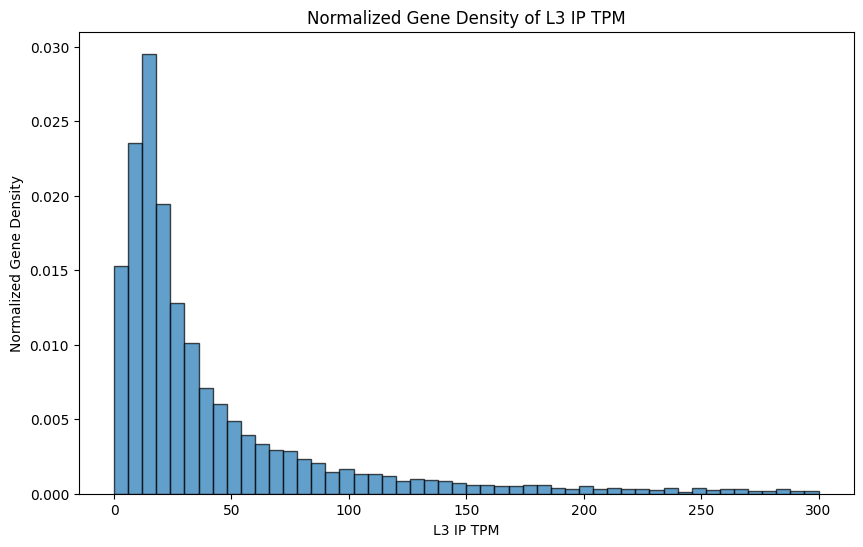

In [121]:
#L3 IP TPM histogram
#Set bin edges for histogram
bin = np.linspace(0, 300, 51)

#Figure specifications
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_filtered_tpm['L3 IP           TPM'], bins=bin, alpha=0.7, density=True, edgecolor='black', linewidth=1)
plt.xlabel('L3 IP TPM')
plt.ylabel('Normalized Gene Density')
plt.title('Normalized Gene Density of L3 IP TPM')
#plt.savefig('L3_IP_TPM_histogram.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Normalized Gene Density of L3 IP TPM (Zero Filtered)')

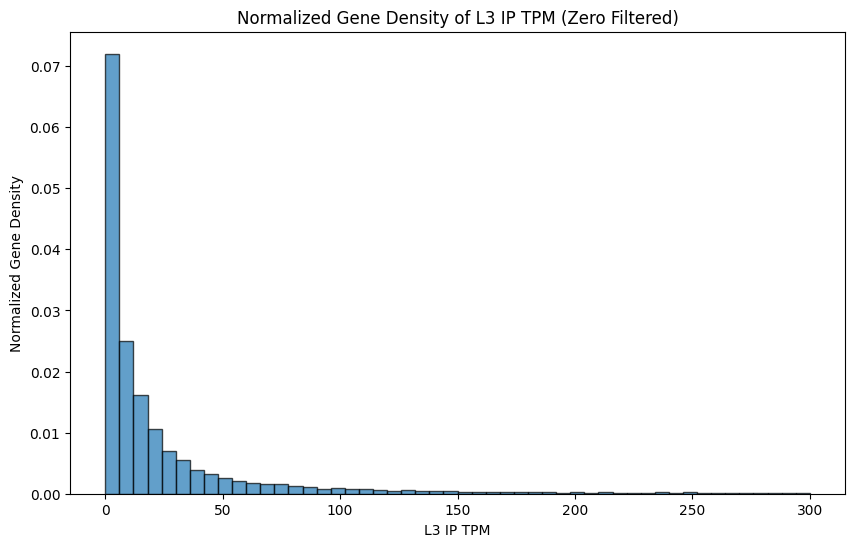

In [122]:
#L3 IP TPM histogram
#Set bin edges for histogram
bin = np.linspace(0, 300, 51)

#Figure specifications
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_zero_filtered_tpm['L3 IP           TPM'], bins=bin, alpha=0.7, density=True, edgecolor='black', linewidth=1)
plt.xlabel('L3 IP TPM')
plt.ylabel('Normalized Gene Density')
plt.title('Normalized Gene Density of L3 IP TPM (Zero Filtered)')
#plt.savefig('L3_IP_TPM_histogram.png', dpi=300, bbox_inches='tight')

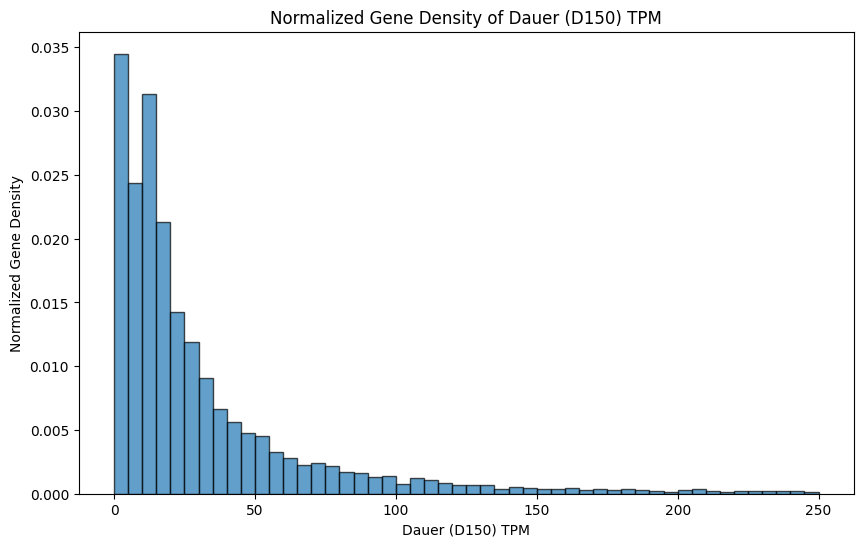

In [123]:
#Dauer (D150) TPM histogram
#Set bin edges for histogram
bin = np.linspace(0, 250, 51)

#Figure specifications
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_filtered_tpm['Dauer (D150)   TPM'], bins=bin, alpha=0.7, density=True, edgecolor='black', linewidth=1)
plt.xlabel('Dauer (D150) TPM')
plt.ylabel('Normalized Gene Density')
plt.title('Normalized Gene Density of Dauer (D150) TPM')
plt.show()
#plt.savefig('Dauer_TPM_histogram.png', dpi=300, bbox_inches='tight')

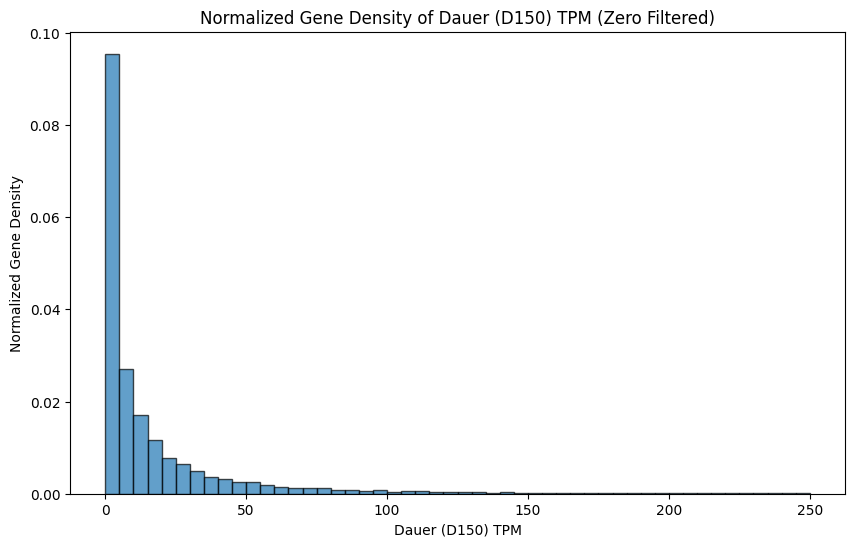

In [124]:
#Dauer (D150) TPM histogram
#Set bin edges for histogram
bin = np.linspace(0, 250, 51)

#Figure specifications
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_zero_filtered_tpm['Dauer (D150)   TPM'], bins=bin, alpha=0.7, density=True, edgecolor='black', linewidth=1)
plt.xlabel('Dauer (D150) TPM')
plt.ylabel('Normalized Gene Density')
plt.title('Normalized Gene Density of Dauer (D150) TPM (Zero Filtered)')
plt.show()
#plt.savefig('Dauer_TPM_histogram.png', dpi=300, bbox_inches='tight')

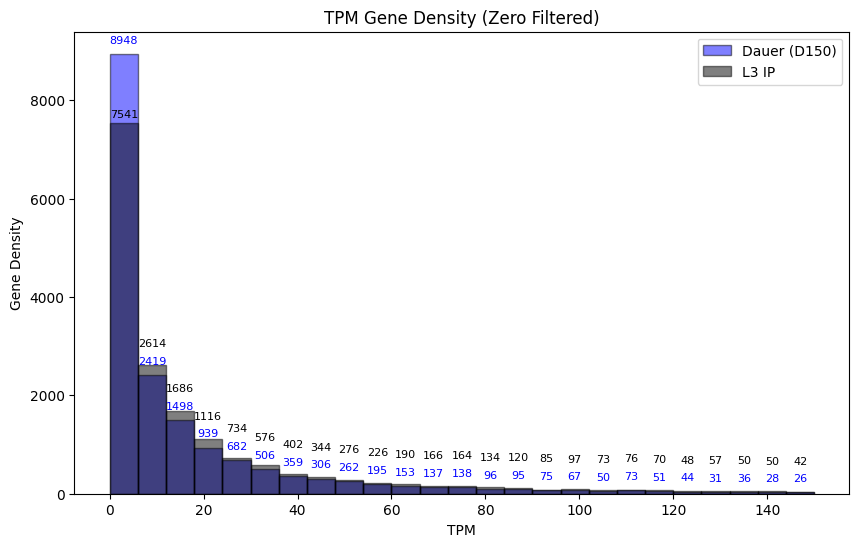

In [125]:
#L3 and Dauer (D150) TPM histogram
#Set bin edges for histogram
bin = np.linspace(0, 150, 26)

#Figure specifications
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_zero_filtered_tpm['Dauer (D150)   TPM'], color='blue', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1)
n2, bins2, patches2 = plt.hist(df_zero_filtered_tpm['L3 IP           TPM'], color='black', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1)
#Optionally: Add numbers above each bar
for i in range(len(n)):
    plt.text(bins[i] + (bins[i+1] - bins[i])/2, n[i] + 0.02*max(n), str(int(n[i])), ha='center', va='bottom', color='blue', fontsize=8)
for i in range(1, len(n2)):
    plt.text(bins2[i] + (bins[i+1] - bins[i])/2, n[i] + 0.06*max(n), str(int(n2[i])), ha='center', va='bottom', color= 'black', fontsize=8)
plt.text(bins2[0] + (bins2[1] - bins2[0])/2, n2[0] + 0.01*max(n2), str(int(n2[0])), ha='center', va='bottom', color= 'black', fontsize=8)
plt.xlabel('TPM')
plt.ylabel('Gene Density')
plt.title('TPM Gene Density (Zero Filtered)')
plt.legend(['Dauer (D150)', 'L3 IP'])
#plt.savefig('TPM Gene Density Zero Filtered histogram.png', dpi=300, bbox_inches='tight')

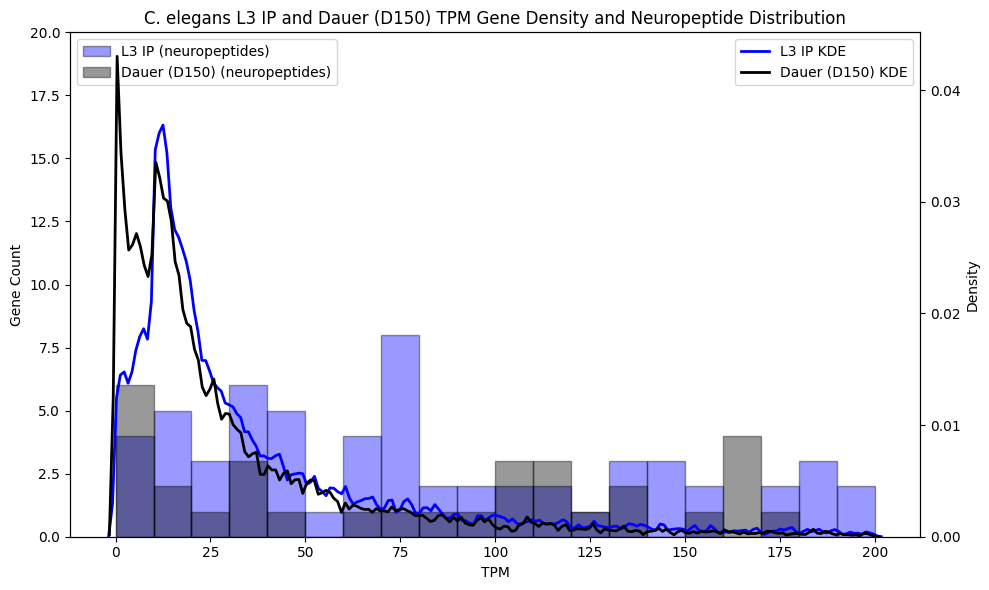

In [126]:
#Dual-axis Overlayed histogram of L3 IP and Dauer (D150) TPM
data1 = df_filtered_tpm['L3 IP           TPM']
data2 = df_filtered_tpm['Dauer (D150)   TPM']
data3 = df_filtered_tpm_neuropep['L3 IP           TPM']
data4 = df_filtered_tpm_neuropep['Dauer (D150)   TPM']

bins = np.linspace(0, 200, 21)

plt.figure(figsize=(10, 6))
# Histogram on left y-axis
ax1 = plt.gca()
ax1.hist(data3, bins=bins, alpha=0.4, color='blue', label='L3 IP (neuropeptides)', density=False, edgecolor='black')
ax1.hist(data4, bins=bins, alpha=0.4, color='black', label='Dauer (D150) (neuropeptides)', density=False, edgecolor='black')
ax1.set_xlabel('TPM')
ax1.set_ylabel('Gene Count')
ax1.set_ylim(0, 20)
ax1.legend(loc='upper left')

# KDE on right y-axis
ax2 = ax1.twinx()
sns.kdeplot(data1[data1 < 200], color='blue', label='L3 IP KDE', bw_adjust=0.1, linewidth=2, ax=ax2)
sns.kdeplot(data2[data2 < 200], color='black', label='Dauer (D150) KDE', bw_adjust=0.1, linewidth=2, ax=ax2)
ax2.set_ylabel('Density')
#ax2.set_ylim(0, 0.04)
ax2.legend(loc='upper right')

plt.title('C. elegans L3 IP and Dauer (D150) TPM Gene Density and Neuropeptide Distribution')
plt.tight_layout()
plt.savefig('TPM_dual_axis_histogram.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Normalized Gene Density of L3 IP RPKM')

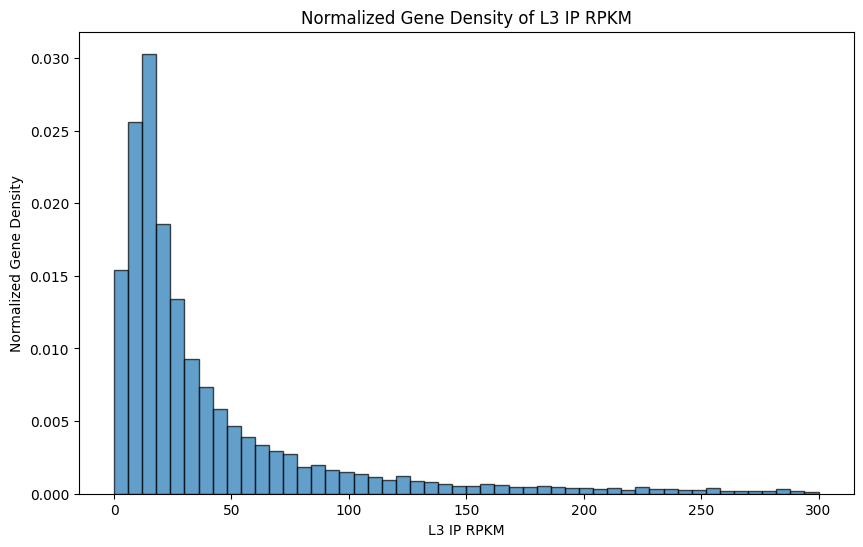

In [127]:
#L3 IP RPKM histogram
#Set bin edges for histogram
bin = np.linspace(0, 300, 51)

#Figure specifications
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_filtered_rpkm['L3 IP        RPKM'], bins=bin, alpha=0.7, density=True, edgecolor='black', linewidth=1)
plt.xlabel('L3 IP RPKM')
plt.ylabel('Normalized Gene Density')
plt.title('Normalized Gene Density of L3 IP RPKM')
#plt.savefig('L3_IP_RPKM_histogram.png', dpi=300, bbox_inches='tight')


Text(0.5, 1.0, 'Normalized Gene Density of Dauer (D150) RPKM')

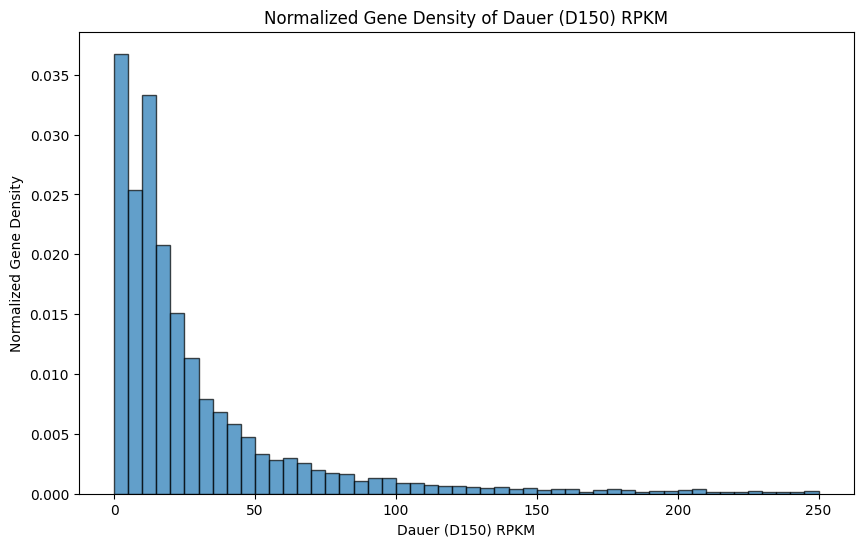

In [128]:
#Dauer (D150) RPKM histogram
#Set bin edges for histogram
bin = np.linspace(0, 250, 51)

#Figure specifications
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_filtered_rpkm['Dauer (D150) RPKM'], bins=bin, alpha=0.7, density=True, edgecolor='black', linewidth=1)
plt.xlabel('Dauer (D150) RPKM')
plt.ylabel('Normalized Gene Density')
plt.title('Normalized Gene Density of Dauer (D150) RPKM')
#plt.savefig('Dauer_RPKM_histogram.png', dpi=300, bbox_inches='tight')

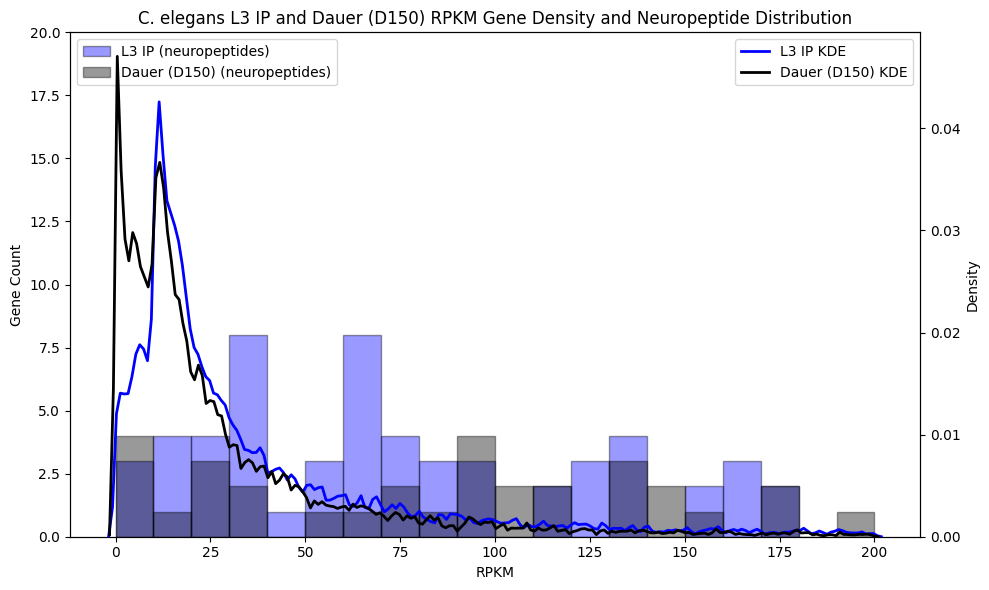

In [129]:
#Dual-axis Overlayed histogram of L3 IP and Dauer (D150) RPKM
data1 = df_filtered_rpkm['L3 IP        RPKM']
data2 = df_filtered_rpkm['Dauer (D150) RPKM']
data3 = df_filtered_rpkm_neuropep['L3 IP        RPKM']
data4 = df_filtered_rpkm_neuropep['Dauer (D150) RPKM']

bins = np.linspace(0, 200, 21)
plt.figure(figsize=(10, 6))

# Histogram on left y-axis
ax1 = plt.gca()
ax1.hist(data3, bins=bins, alpha=0.4, color='blue', label='L3 IP (neuropeptides)', density=False, edgecolor='black')
ax1.hist(data4, bins=bins, alpha=0.4, color='black', label='Dauer (D150) (neuropeptides)', density=False, edgecolor='black')
ax1.set_xlabel('RPKM')
ax1.set_ylabel('Gene Count')
ax1.set_ylim(0, 20)
ax1.legend(loc='upper left')

# KDE on right y-axis
ax2 = ax1.twinx()
sns.kdeplot(data1[data1 < 200], color='blue', label='L3 IP KDE', bw_adjust=0.1, linewidth=2, ax=ax2)
sns.kdeplot(data2[data2 < 200], color='black', label='Dauer (D150) KDE', bw_adjust=0.1, linewidth=2, ax=ax2)
ax2.set_ylabel('Density')
#ax2.set_ylim(0, 0.04)
ax2.legend(loc='upper right')
plt.title('C. elegans L3 IP and Dauer (D150) RPKM Gene Density and Neuropeptide Distribution')
plt.tight_layout()
#plt.savefig('RPKM_dual_axis_histogram.png', dpi=300, bbox_inches='tight')

## Task 3: New Analysis

1) Want to use TPM instead of RPKM because only TPM is comparable across datasets
2) Want to focus on specific regions of the distribution
3) Want to use unfiltered data (exclude zero values only for less biased approach)

#### L3 and Dauer Normalized Read Density Overview (Transcripts per Million) 

In [152]:
def stack_images_vertically(img1:Union[Image.Image,str], img2:Union[Image.Image,str], overlap:int=0, offset:int=0) -> Image:
    """
    Stacks two images vertically with a specified pixel overlap and horizontal offset for the second image.

    Parameters
    ----------
    img_path1 : Image.Image or str
        Image or path to the first (top) image file.
    img_path2 : Image.Image or str
        Image to the second (bottom) image file.
    overlap : int, optional
        Number of pixels to overlap the second image with the first image vertically (default is 0).
    offset : int, optional
        Number of pixels to offset the second image horizontally (default is 0).

    Returns
    -------
    PIL.Image
        The combined image object with the two images stacked vertically.
    """
    if isinstance(img1, str):
        image1 = Image.open(img1)
    else:
        image1 = img1.copy()

    if isinstance(img2, str):
        image2 = Image.open(img2)
    else:
        image2 = img2.copy()

    #Crop second image to remove title
    image2 = image2.crop((0, 73, image2.width, image2.height))

    # Get image dimensions
    width1, height1 = image1.size
    width2, height2 = image2.size

    # Calculate dimensions of combined image
    combined_width = max(width1, width2)
    combined_height = height1 + height2 - overlap

    # Create new image with combined dimensions
    new_image = Image.new('RGB', (combined_width, combined_height), color='white')

    # Paste first image at the top
    new_image.paste(image1, (0, 0))

    # Paste second image below first image with overlap
    new_image.paste(image2, (0 + offset, height1 - overlap))

    return new_image

In [169]:
def make_custom_histogram(worm_df: pd.DataFrame, worm_df2: pd.DataFrame, output_list: str, group: str = 'Group', random_seed=44, gene_list=False, save_imgs=False, img_output:str=None, img2_output:str=None):
    """
    Creates sophisticated mirrored histograms with KDE overlays for comparing gene expression data.
    
    This function generates two complementary visualizations:
    1. A standard histogram showing log₁₀(TPM) distribution across all genes
    2. A mirrored (inverted) histogram showing the same data filtered for a specific gene group
    
    Both plots include kernel density estimate (KDE) overlays and can be saved as image files.
    The function also supports exporting gene lists binned by expression levels.
    
    Parameters
    ----------
    worm_df : pd.DataFrame
        Main dataframe containing all gene expression data. Must have columns matching 
        the pattern r'^[A-Za-z]\d{3}' (e.g., 'L450', 'D819') and contain TPM columns.
    worm_df2 : pd.DataFrame
        Filtered dataframe containing subset of genes for the specific group of interest 
        (e.g., neuropeptides, ion channels, GPCRs). Must have the same column structure as worm_df.
    output_list : str
        File path for exporting Excel file with binned gene lists (when gene_list=True).
    group : str, optional
        Name of the gene group being analyzed, used for plot titles and y-axis labels 
        (default is 'Group').
    random_seed : int, optional
        Seed for reproducible color generation across different conditions (default is 44).
    gene_list : bool, optional
        Whether to export binned gene lists to Excel file (default is False).
    save_imgs : bool, optional
        Whether to save histogram images to files (default is False).
    img_output : str, optional
        File path for saving the first histogram image (required if save_imgs=True).
    img2_output : str, optional
        File path for saving the second histogram image (required if save_imgs=True).
    
    Returns
    -------
    tuple[matplotlib.figure.Figure, matplotlib.figure.Figure]
        A tuple containing:
        - fig1: Main histogram figure showing all genes with normal y-axis
        - fig2: Mirrored histogram figure showing filtered genes with inverted y-axis
    
    Raises
    ------
    ValueError
        If column names in either dataframe don't match the required r'^[A-Za-z]\d{3}' pattern.
    
    Notes
    -----
    - The function expects TPM (Transcripts Per Million) columns matching the regex r'^(L|D).*TPM'
    - Log₁₀ transformation is applied to TPM values for visualization
    - The second histogram has an inverted y-axis to create a mirrored effect
    - Random colors are generated for each condition for consistent visualization across plots
    - Bin edges are automatically calculated based on the min/max of all TPM values
    - When gene_list=True, genes are binned by expression level and exported to Excel with TPM ranges
    - The function automatically filters out empty bins in the exported gene lists
    
    Examples
    --------
    >>> # Create neuropeptide gene density histogram
    >>> fig1, fig2 = make_custom_histogram(
    ...     worm_df=df_zero_filtered_tpm,
    ...     worm_df2=df_zero_filtered_neuropep,
    ...     group='Neuropeptide',
    ...     gene_list=True,
    ...     save_imgs=True,
    ...     img_output='neuropeptide_all.png',
    ...     img2_output='neuropeptide_filtered.png',
    ...     output_list='neuropeptide_bins.xlsx'
    ... )
    """
    #Requires columns of dataframe df to start with format 'XYYY'. For example, L450.
    pattern = re.compile(r'^[A-Za-z]\d{3}')
    invalid_cols = [col for col in worm_df.columns[1:-1] if not pattern.match(col)]
    invalid_cols2 = [col for col in worm_df2.columns[1:-1] if not pattern.match(col)]
    if invalid_cols or invalid_cols2:
        raise ValueError(f"Invalid column names: {invalid_cols + invalid_cols2}. All columns must match 'XYYY' starting format.")

    #Data
    worm_cols = worm_df.filter(regex=r'^(L|D).*TPM').columns #Get relevant columns for each worm
    worm_df_log = np.log10(worm_df[worm_cols]) #Get log10 dataframe of columns of interest
    worm_group_df_log = np.log10(worm_df2[worm_cols]) #Get log10 dataframe of columns of interest for group of interest
    worm_dict = {col: worm_df_log[col].values for col in worm_cols} #Convert to dictionary to iterate over
    worm_dict_group = {col: worm_group_df_log[col].values for col in worm_cols} #Convert to dictionary to iterate over
    hist_results = {}
    hist_results_group = {}

    #Set bin edges for histogram
    bin = np.linspace(min(i.min() for i in worm_dict.values()), max(i.max() for i in worm_dict.values()), 101)

    #Generate random colors
    np.random.seed(random_seed)  # For reproducibility
    colors = np.random.rand(len(worm_dict), 3)  # Generate random colors

    #First figure specifications
    fig1 = plt.figure(num=1, figsize=(10, 6))
    for i, worm in enumerate(worm_dict.keys()):
        n, bins, patches = plt.hist(worm_dict[worm], color=colors[i], bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1, align='mid')
        hist_results[worm] = {'n': n, 'bins': bins, 'patches': patches} #Record histogram results for each worm
    plt.xlabel('log$_{10}$(TPM)')
    plt.ylabel('# of Genes', labelpad=15)
    plt.xlim(min([hist_results[worm]['bins'].min() - 0.5 for worm in worm_dict.keys()]), max([hist_results[worm]['bins'].max() + 0.5 for worm in worm_dict.keys()]))
    plt.ylim(0, max([hist_results[worm]['n'].max() * 1.1 for worm in worm_dict.keys()]))
    plt.title(f"{group} Gene Density")
    plt.legend([worm.split(' ')[0] for worm in worm_dict.keys()], loc='upper left')

    # Kernel Density Estimate (KDE) on right y-axis
    ax2 = plt.twinx()
    for i, worm in enumerate(worm_dict.keys()):
        sns.kdeplot(worm_dict[worm], color=colors[i], label=f'{worm} KDE', bw_adjust=1, linewidth=1, ax=ax2, fill=False, alpha=1)
    ax2.set_ylabel('Density', labelpad=15)
    ax2.yaxis.set_major_locator(MultipleLocator(0.1))
    ax2.legend([f"{worm.split(' ')[0]} KDE" for worm in worm_dict.keys()], loc='upper right')
    if save_imgs:
        plt.savefig(img_output, dpi=300, bbox_inches='tight')

    #Second figure specifications
    fig2 = plt.figure(num=2, figsize=(10, 6))
    ax = plt.gca()
    for i, worm in enumerate(worm_dict_group.keys()):
        n, bins, patches = ax.hist(worm_dict_group[worm], color=colors[i], bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1, align='mid')
        hist_results_group[worm] = {'n': n, 'bins': bins, 'patches': patches} #Record histogram results for each worm
    ax.set_xlabel('log$_{10}$(TPM)')
    ax.set_ylabel(f'# of {group} Genes', labelpad=15)
    ax.set_xlim(min([hist_results[worm]['bins'].min() - 0.5 for worm in worm_dict.keys()]), max([hist_results[worm]['bins'].max() + 0.5 for worm in worm_dict.keys()]))
    ax.set_ylim(0, max([hist_results_group[worm]['n'].max() * 1.1 for worm in worm_dict.keys()]))
    ax.invert_yaxis()

    #Kernal Density Estimate (KDE) on right y-axis
    ax2 = ax.twinx()
    for i, worm in enumerate(worm_dict_group.keys()):
        sns.kdeplot(worm_dict_group[worm], color=colors[i], label=f'{worm} KDE', bw_adjust=1, linewidth=1, ax=ax2, fill=False, alpha=1)
    ax2.invert_yaxis()
    ax2.set_ylabel('Density', labelpad=15)
    ax2.yaxis.set_major_locator(MultipleLocator(0.1))
    if save_imgs:
        plt.savefig(img2_output, dpi=300, bbox_inches='tight')

    #Export gene list
    if gene_list:
        
        #Initialize bin dictionaries
        bin_indices_dict = {}
        bin_dict_worm = {}

        #Get correspondance between group gene and which bin it belongs to
        for worm in worm_dict_group.keys():
            bin_indices_dict[worm] = np.digitize(worm_dict_group[worm], bin)

        #Get gene names for each bin
        for worm in worm_dict_group.keys():
            bin_dict = {} # Clear bin_dict for each worm
            for i in range(1, len(bin)):
                genes_in_bin = worm_df2['Name'][(bin_indices_dict[worm] == i)].tolist()
                bin_dict[i] = genes_in_bin
            bin_dict_worm[worm] = bin_dict
            
        #Make Group Gene Table
        df_bins = pd.DataFrame({f'{col}_genes': pd.Series(bin_dict_worm[col]) for col in worm_cols})

        #Add bin range (in TPM) as a new column
        df_bins['bin_range'] = [f"{10**bin[i-1]:.3f} - {10**bin[i]:.3f}" for i in df_bins.index]

        #Set bin range as first column
        first_col = df_bins.pop('bin_range')
        df_bins.insert(0, 'bin_range', first_col)

        #Filter out rows where both gene lists are empty
        cols_to_check = [col for col in df_bins.columns if col != 'bin_range']
        df_bins = df_bins[df_bins[cols_to_check].applymap(lambda x: len(x) > 0 if isinstance(x, list) else False).any(axis=1)]

        df_bins.to_excel(output_list, index=False)
    
    return fig1, fig2

In [170]:
def plt_to_pil(fig):
    """Convert a matplotlib figure (plt) to a PIL Image"""
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
                #bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf)
    return img

/tmp/ipykernel_5178/1002977980.py:170: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_bins = df_bins[df_bins[cols_to_check].applymap(lambda x: len(x) > 0 if isinstance(x, list) else False).any(axis=1)]


(-0.5, 999.5, 1061.5, -0.5)

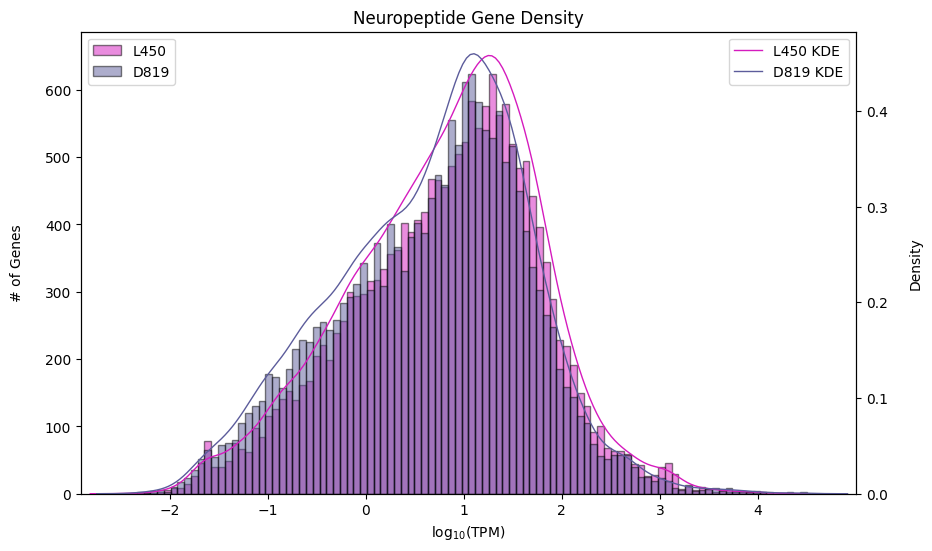

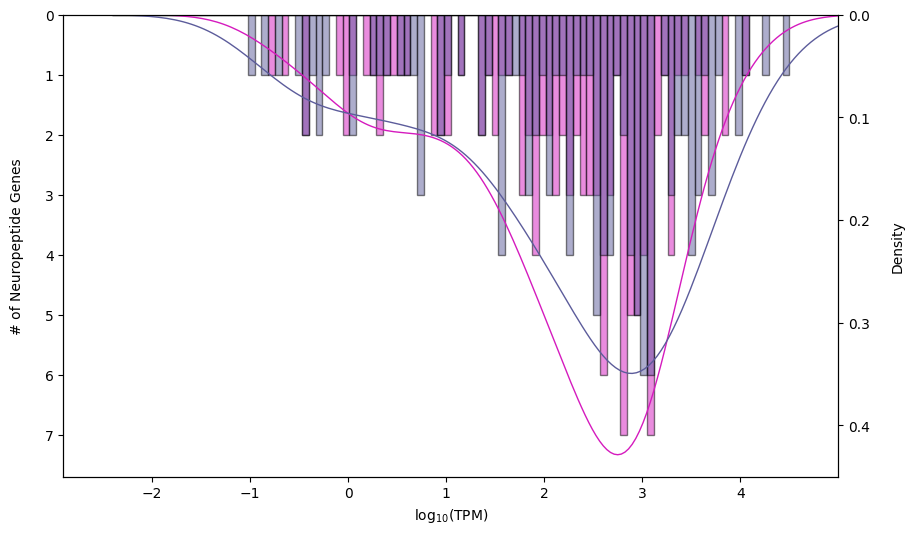

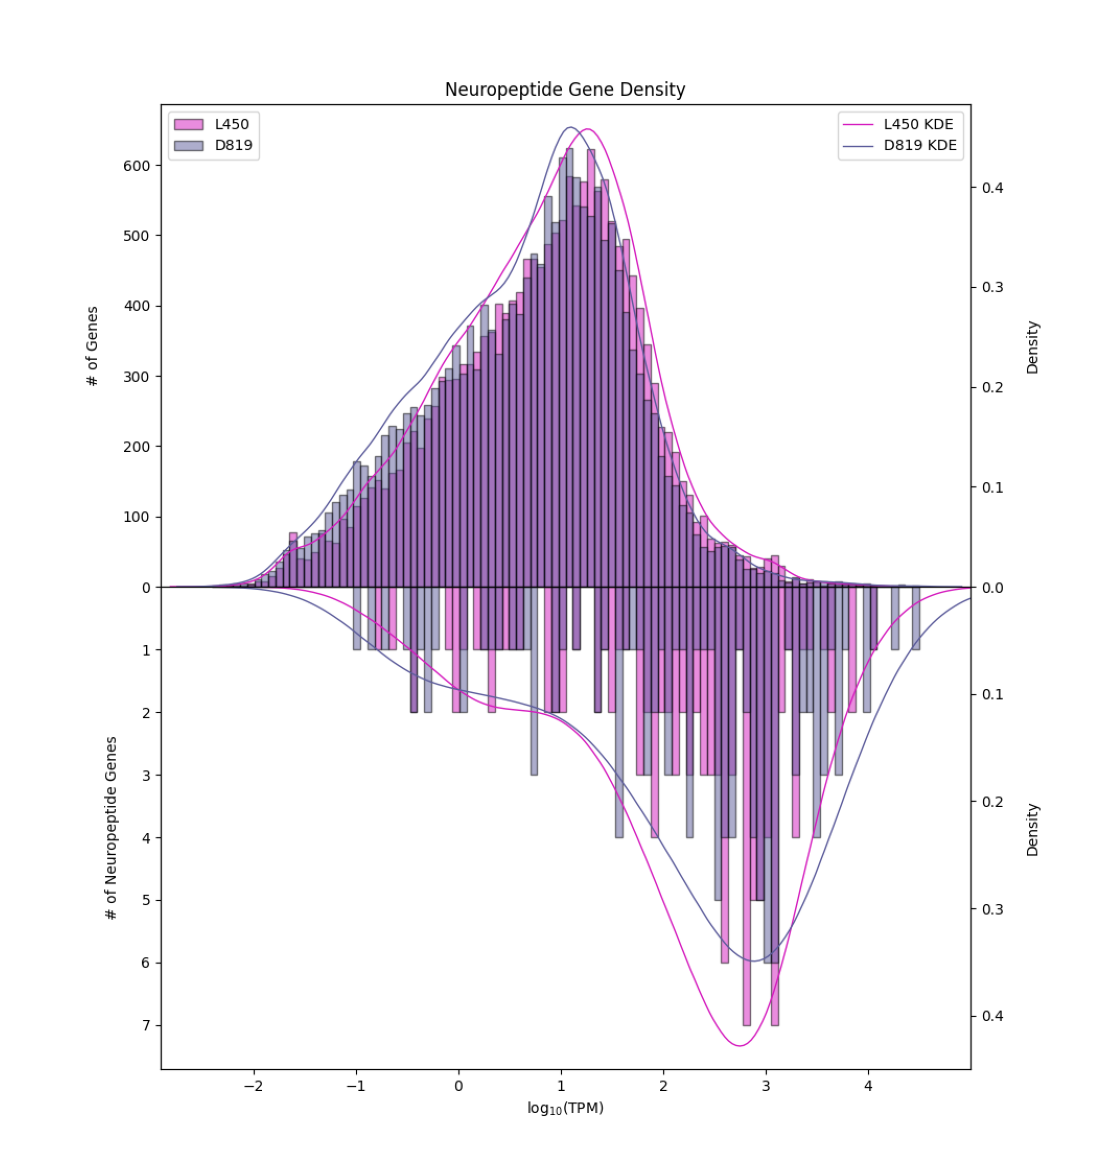

In [171]:
#Make neuropeptide gene density histogram
fig1, fig2 = make_custom_histogram(
    worm_df=df_zero_filtered_tpm,
    worm_df2=df_zero_filtered_neuropep,
    group='Neuropeptide',
    img_output='test.png',
    img2_output='test2.png',
    random_seed=44,
    gene_list=True,
    save_imgs=True,
    output_list='test.xlsx')

new_image = stack_images_vertically(plt_to_pil(fig1),
                                    plt_to_pil(fig2),
                                    overlap=65,
                                    offset=0)

plt.figure(dpi=300)
plt.imshow(new_image)
plt.axis('off')
# Save the combined image
#new_image.save('Figures/D819 vs L4/Combined_Figure.png', dpi=(300, 300))

/tmp/ipykernel_5178/1002977980.py:170: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_bins = df_bins[df_bins[cols_to_check].applymap(lambda x: len(x) > 0 if isinstance(x, list) else False).any(axis=1)]


(-0.5, 999.5, 1061.5, -0.5)

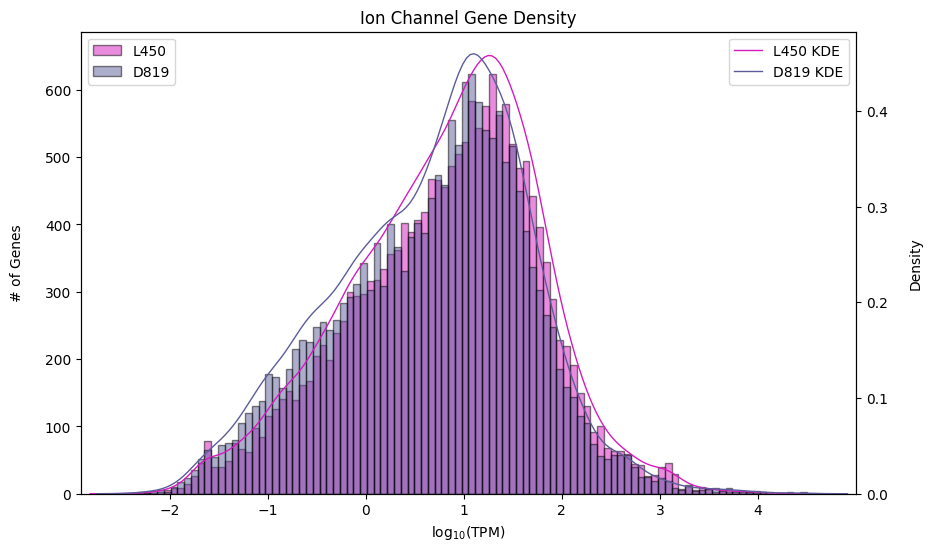

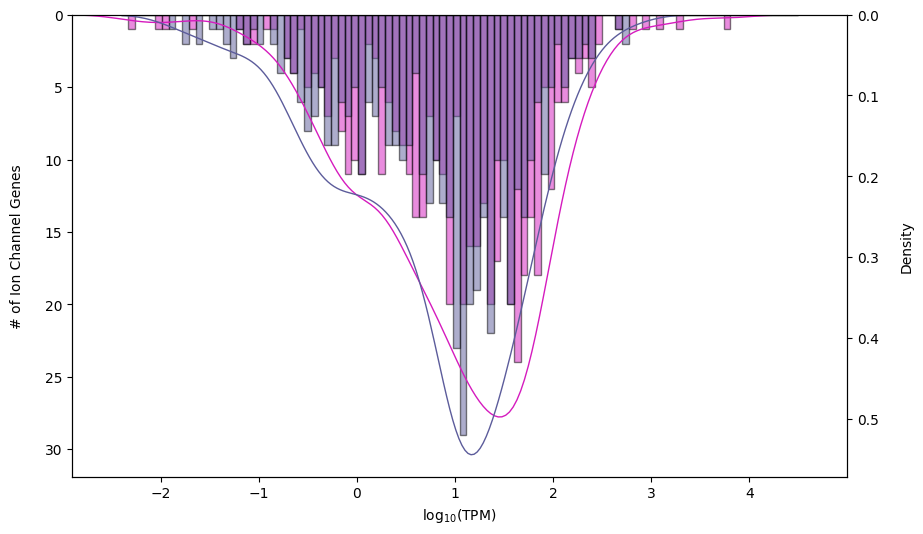

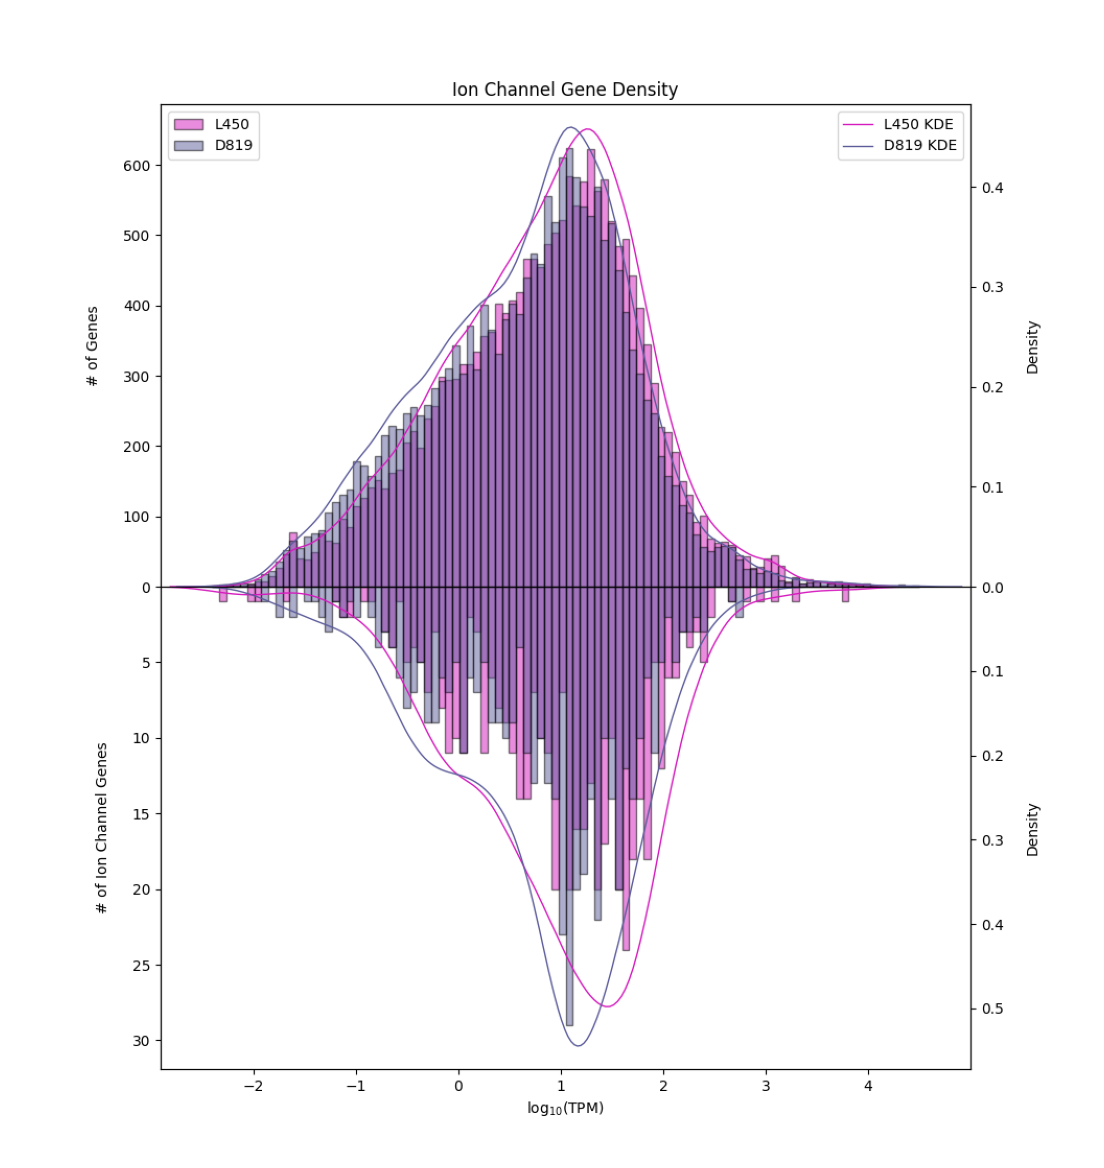

In [174]:
#Make ion channel gene density histogram
fig1, fig2 = make_custom_histogram(
    worm_df=df_zero_filtered_tpm,
    worm_df2=df_zero_filtered_ion_channels,
    group='Ion Channel',
    img_output='test.png',
    img2_output='test2.png',
    random_seed=44,
    gene_list=True,
    save_imgs=True,
    output_list='test.xlsx')

new_image = stack_images_vertically(plt_to_pil(fig1),
                                    plt_to_pil(fig2),
                                    overlap=65,
                                    offset=0)

plt.figure(dpi=300)
plt.imshow(new_image)
plt.axis('off')
# Save the combined image
#new_image.save('Figures/D819 vs L4/Combined_Figure.png', dpi=(300, 300))

### Manual Plotting

#### All Genes Histogram

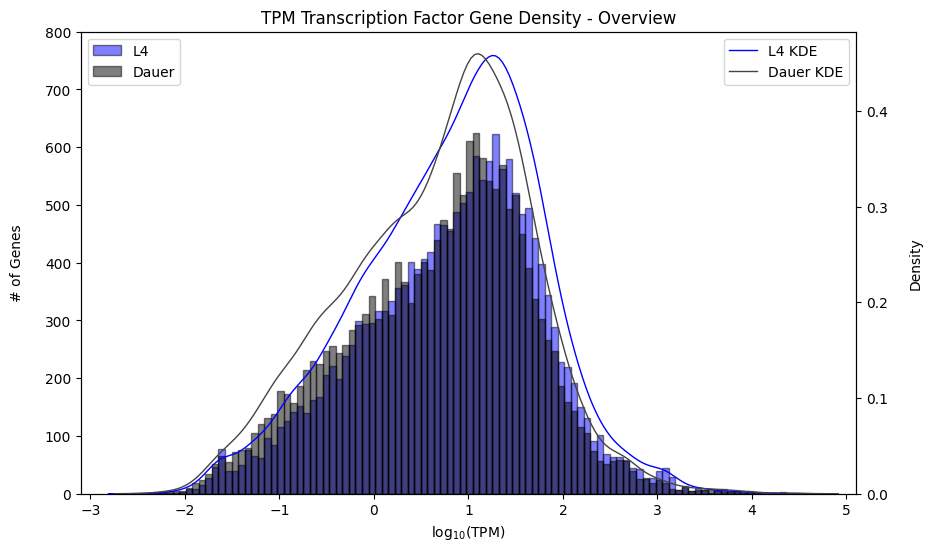

In [113]:
#Data
data_l4 = np.log10(df_zero_filtered_tpm['L450 TPM'])
data_dauer = np.log10(df_zero_filtered_tpm['Dauer (D819) TPM'])

#Set bin edges for histogram
bin = np.linspace(min(data_l4.min(), data_dauer.min()), max(data_l4.max(), data_dauer.max()), 101)

#Figure specifications
plt.figure(figsize=(10, 6))
plt.hist(data_l4, color='blue', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1, align='mid')
plt.hist(data_dauer, color='black', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1, align='mid')
plt.xlabel('log$_{10}$(TPM)')
plt.ylabel('# of Genes', labelpad=15)
plt.xlim(-3.1, 5.1)
plt.ylim(0, 800)
plt.title('TPM Transcription Factor Gene Density - Overview')
plt.legend(['L4', 'Dauer'], loc='upper left')

# Kernal Density Estimate (KDE) on right y-axis
ax2 = plt.twinx()
sns.kdeplot(data_l4, color='blue', label='L4 IP KDE', bw_adjust=1, linewidth=1, ax=ax2, fill=False, alpha=1)
sns.kdeplot(data_dauer, color='#444444', label='Dauer (D819) KDE', bw_adjust=1, linewidth=1, ax=ax2, fill=False, alpha=1)
ax2.set_ylabel('Density', labelpad=15)
ax2.legend(['L4 KDE', 'Dauer KDE'], loc='upper right')
#plt.savefig('Figures/D819 vs L4/Figure 0: Part 1 - Mirrored histogram.png', dpi=300, bbox_inches='tight')

#### Neuropeptide gene histogram

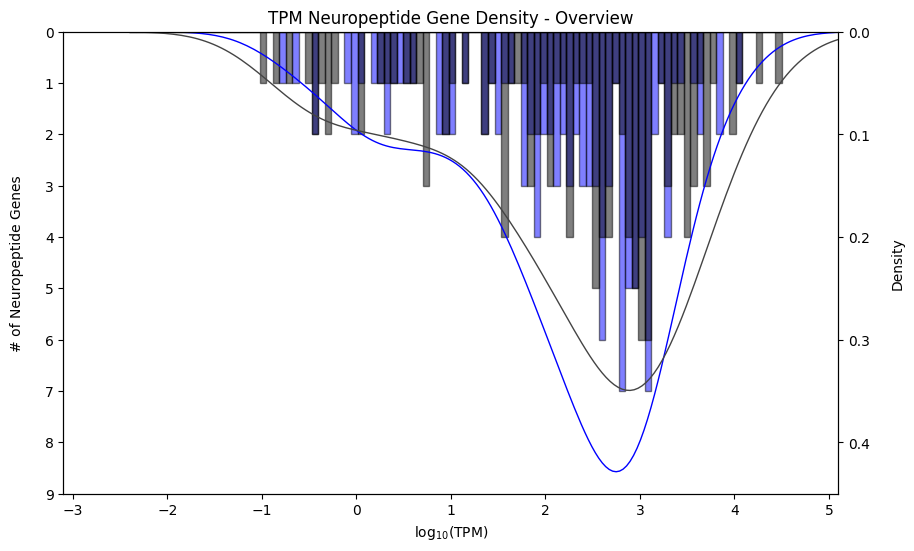

In [158]:
#NOTE: For mirrored histogram, I manually crop and append this plot to the previous plot.

#Data
data_l4 = np.log10(df_zero_filtered_tpm['L450 TPM'])
data_dauer = np.log10(df_zero_filtered_tpm['Dauer (D819) TPM'])
data_l4_neuropep = np.log10(df_zero_filtered_neuropep['L450 TPM'])
data_dauer_neuropep = np.log10(df_zero_filtered_neuropep['Dauer (D819) TPM'])

#Set bin edges for histogram
bin = np.linspace(min(data_l4.min(), data_dauer.min()), max(data_l4.max(), data_dauer.max()), 101)

#Figure specifications
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.hist(data_l4_neuropep, color='blue', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1, align='mid')
ax.hist(data_dauer_neuropep, color='black', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1, align='mid')
ax.set_xlabel('log$_{10}$(TPM)')
ax.set_ylabel('# of Neuropeptide Genes', labelpad=15)
ax.set_xlim(-3.1, 5.1)
ax.set_ylim(0, 9)
ax.invert_yaxis()
ax.set_title('TPM Neuropeptide Gene Density - Overview')

# Kernal Density Estimate (KDE) on right y-axis
ax2 = ax.twinx()
sns.kdeplot(data_l4_neuropep, color='blue', label='L4 KDE', bw_adjust=1, linewidth=1, ax=ax2, fill=False, alpha=1)
sns.kdeplot(data_dauer_neuropep, color='#444444', label='Dauer KDE', bw_adjust=1, linewidth=1, ax=ax2, fill=False, alpha=1)
ax2.invert_yaxis()
ax2.set_ylabel('Density', labelpad=15)
ax2.yaxis.set_major_locator(MultipleLocator(0.1))
plt.savefig('Figures/D819 vs L4/Figure 1: Part 2 - Mirrored Neuropeptide histogram.png', dpi=300, bbox_inches='tight')

#### Exporting Neuropeptide Gene Lists

In [52]:
#Get correspondance between neuropeptide gene and which bin it belongs to
bin_indices_l4 = np.digitize(data_l4_neuropep, bin)
bin_indices_dauer = np.digitize(data_dauer_neuropep, bin)

# Get gene names for each bin
bin_dict_l4={}
bin_dict_dauer={}
for i in range(1, len(bin)):
    genes_in_bin_for_l4 = df_zero_filtered_neuropep['Name'][(bin_indices_l4 == i)].tolist()
    genes_in_bin_for_dauer = df_zero_filtered_neuropep['Name'][(bin_indices_dauer == i)].tolist()
    bin_dict_l4[i] = genes_in_bin_for_l4
    bin_dict_dauer[i] = genes_in_bin_for_dauer
    
#Make Neuropeptide Gene Table
df_bins = pd.DataFrame({
    'L4_genes': pd.Series(bin_dict_l4),
    'Dauer_genes': pd.Series(bin_dict_dauer)
})

# Add bin range (in TPM) as a new column
df_bins['bin_range'] = [f"{10**bin[i-1]:.3f} - {10**bin[i]:.3f}" for i in df_bins.index]

# Set bin range as first column
df_bins = df_bins[['bin_range', 'L4_genes', 'Dauer_genes']]

# Filter out rows where both gene lists are empty
df_bins = df_bins[df_bins['L4_genes'].apply(lambda x: len(x) > 0) | df_bins['Dauer_genes'].apply(lambda x: len(x) > 0)]

df_bins.to_excel('Data/D819 vs L450/Neuropeptide Gene Densities.xlsx', index=False)

#### Ion Channel gene histogram

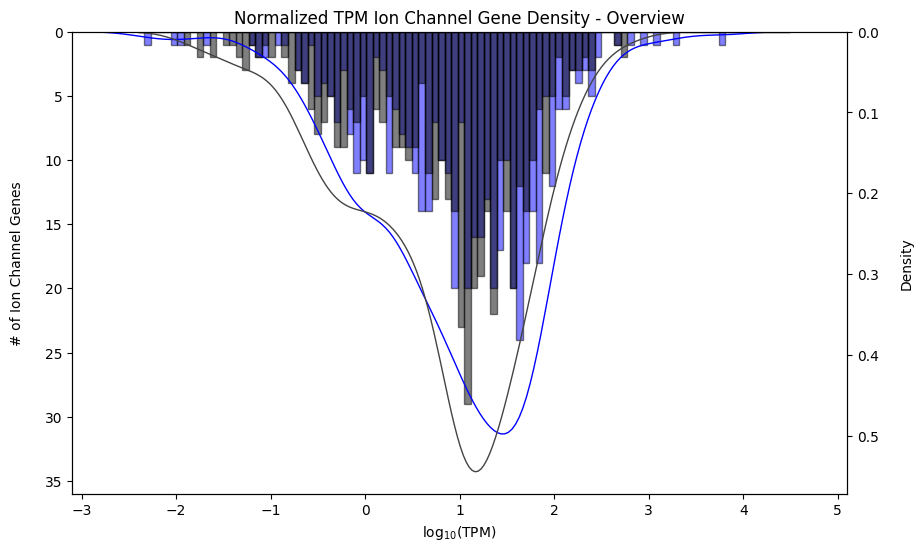

In [53]:
#NOTE: For mirrored histogram, I manually crop and append this plot to the previous plot.

#Data
data_l4 = np.log10(df_zero_filtered_tpm['L450 TPM'])
data_dauer = np.log10(df_zero_filtered_tpm['Dauer (D819) TPM'])
data_l4_ion_channels = np.log10(df_zero_filtered_ion_channels['L450 TPM'])
data_dauer_ion_channels = np.log10(df_zero_filtered_ion_channels['Dauer (D819) TPM'])

#Set bin edges for histogram
bin = np.linspace(min(data_l4.min(), data_dauer.min()), max(data_l4.max(), data_dauer.max()), 101)

#Figure specifications
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.hist(data_l4_ion_channels, color='blue', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1)
ax.hist(data_dauer_ion_channels, color='black', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1)
ax.set_xlabel('log$_{10}$(TPM)')
ax.set_ylabel('# of Ion Channel Genes', labelpad=15)
ax.set_xlim(-3.1, 5.1)
ax.set_ylim(0, 36)
ax.invert_yaxis()
ax.set_title('Normalized TPM Ion Channel Gene Density - Overview')

# Kernal Density Estimate (KDE) on right y-axis
ax2 = ax.twinx()
sns.kdeplot(data_l4_ion_channels, color='blue', label='L4 KDE', bw_adjust=1, linewidth=1, ax=ax2, fill=False, alpha=1)
sns.kdeplot(data_dauer_ion_channels, color='#444444', label='Dauer KDE', bw_adjust=1, linewidth=1, ax=ax2, fill=False, alpha=1)
ax2.invert_yaxis()
ax2.set_ylabel('Density', labelpad=15)
plt.savefig('Figures/D819 vs L4/Figure 2: Part 2 - Mirrored Ion Channel histogram.png', dpi=300, bbox_inches='tight')


#### Exporting Ion Channel Gene Lists

In [54]:
#Get correspondance between ion channel gene and which bin it belongs to
bin_indices_l4 = np.digitize(data_l4_ion_channels, bin)
bin_indices_dauer = np.digitize(data_dauer_ion_channels, bin)

# Get gene names for each bin
bin_dict_l4={}
bin_dict_dauer={}
for i in range(1, len(bin)):
    genes_in_bin_for_l4 = df_zero_filtered_ion_channels['Name'][(bin_indices_l4 == i)].tolist()
    genes_in_bin_for_dauer = df_zero_filtered_ion_channels['Name'][(bin_indices_dauer == i)].tolist()
    bin_dict_l4[i] = genes_in_bin_for_l4
    bin_dict_dauer[i] = genes_in_bin_for_dauer

#Make Ion Channel Gene Table
df_bins = pd.DataFrame({
    'L4_genes': pd.Series(bin_dict_l4),
    'Dauer_genes': pd.Series(bin_dict_dauer)
})

# Add bin range (in TPM) as a new column
df_bins['bin_range'] = [f"{10**bin[i-1]:.3f} - {10**bin[i]:.3f}" for i in df_bins.index]

# Set bin range as first column
df_bins = df_bins[['bin_range', 'L4_genes', 'Dauer_genes']]

# Filter out rows where both gene lists are empty
df_bins = df_bins[df_bins['L4_genes'].apply(lambda x: len(x) > 0) | df_bins['Dauer_genes'].apply(lambda x: len(x) > 0)]

df_bins.to_excel('Data/D819 vs L450/Ion Channel Gene Densities.xlsx', index=False)

#### GPCR gene histogram

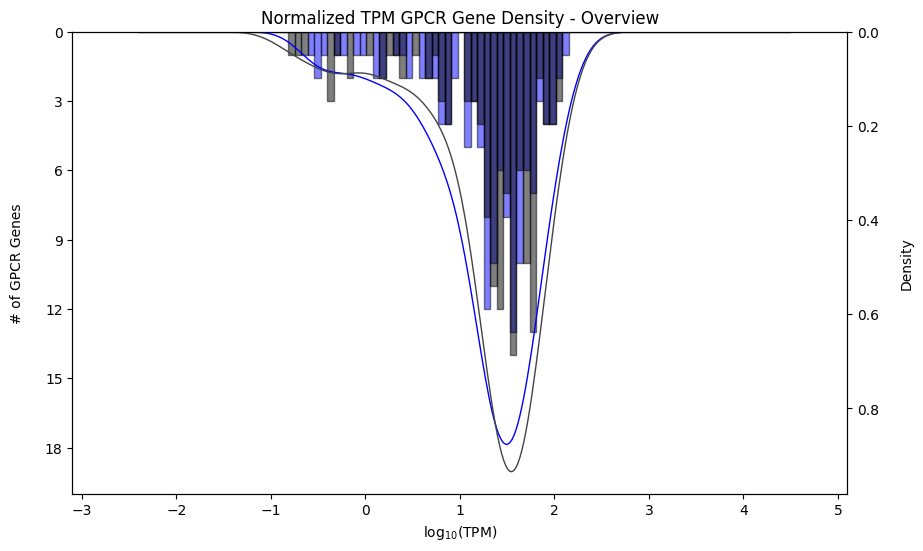

In [55]:
#NOTE: For mirrored histogram, I manually crop and append this plot to the previous plot.

#Data
data_l4 = np.log10(df_zero_filtered_tpm['L450 TPM'])
data_dauer = np.log10(df_zero_filtered_tpm['Dauer (D819) TPM'])
data_l4_gpcrs = np.log10(df_zero_filtered_gpcrs['L450 TPM'])
data_dauer_gpcrs = np.log10(df_zero_filtered_gpcrs['Dauer (D819) TPM'])

#Set bin edges for histogram
bin = np.linspace(min(data_l4.min(), data_dauer.min()), max(data_l4.max(), data_dauer.max()), 101)

#Figure specifications
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.hist(data_l4_gpcrs, color='blue', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1)
ax.hist(data_dauer_gpcrs, color='black', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1)
ax.set_xlabel('log$_{10}$(TPM)')
ax.set_ylabel('# of GPCR Genes', labelpad=15)
ax.set_xlim(-3.1, 5.1)
ax.set_ylim(0, 20)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MultipleLocator(3))
ax.invert_yaxis()
ax.set_title('Normalized TPM GPCR Gene Density - Overview')

# Kernal Density Estimate (KDE) on right y-axis
ax2 = ax.twinx()
sns.kdeplot(data_l4_gpcrs, color='blue', label='L4 KDE', bw_adjust=1, linewidth=1, ax=ax2, fill=False, alpha=1)
sns.kdeplot(data_dauer_gpcrs, color='#444444', label='Dauer KDE', bw_adjust=1, linewidth=1, ax=ax2, fill=False, alpha=1)
ax2.invert_yaxis()
ax2.set_ylabel('Density', labelpad=15)
plt.savefig('Figures/D819 vs L4/Figure 3: Part 2 - Mirrored GPCR histogram.png', dpi=300, bbox_inches='tight')

#### Exporting GPCR Gene Lists

In [56]:
#Get correspondance between GPCR gene and which bin it belongs to
bin_indices_l4 = np.digitize(data_l4_gpcrs, bin)
bin_indices_dauer = np.digitize(data_dauer_gpcrs, bin)

# Get gene names for each bin
bin_dict_l4={}
bin_dict_dauer={}
for i in range(1, len(bin)):
    genes_in_bin_for_l4 = df_zero_filtered_gpcrs['Name'][(bin_indices_l4 == i)].tolist()
    genes_in_bin_for_dauer = df_zero_filtered_gpcrs['Name'][(bin_indices_dauer == i)].tolist()
    bin_dict_l4[i] = genes_in_bin_for_l4
    bin_dict_dauer[i] = genes_in_bin_for_dauer

#Make GPCR Gene Table
df_bins = pd.DataFrame({
    'L4_genes': pd.Series(bin_dict_l4),
    'Dauer_genes': pd.Series(bin_dict_dauer)
})

# Add bin range (in TPM) as a new column
df_bins['bin_range'] = [f"{10**bin[i-1]:.3f} - {10**bin[i]:.3f}" for i in df_bins.index]

# Set bin range as first column
df_bins = df_bins[['bin_range', 'L4_genes', 'Dauer_genes']]

# Filter out rows where both gene lists are empty
df_bins = df_bins[df_bins['L4_genes'].apply(lambda x: len(x) > 0) | df_bins['Dauer_genes'].apply(lambda x: len(x) > 0)]

df_bins.to_excel('Data/D819 vs L450/GPCR Gene Densities.xlsx', index=False)

#### Gap Junction gene histogram

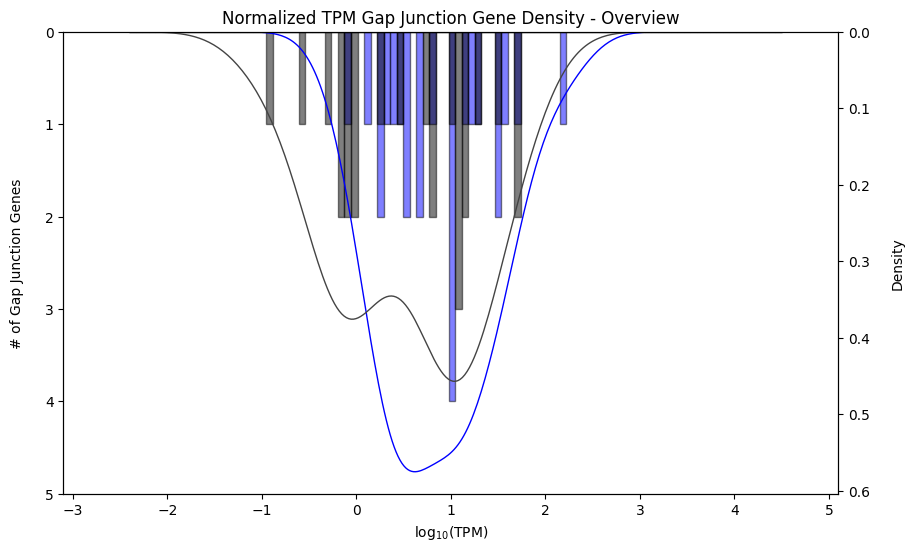

In [59]:
#NOTE: For mirrored histogram, I manually crop and append this plot to the previous plot.

#Data
data_l4 = np.log10(df_zero_filtered_tpm['L450 TPM'])
data_dauer = np.log10(df_zero_filtered_tpm['Dauer (D819) TPM'])
data_l4_gap_junctions = np.log10(df_zero_filtered_gap_junctions['L450 TPM'])
data_dauer_gap_junctions = np.log10(df_zero_filtered_gap_junctions['Dauer (D819) TPM'])

#Set bin edges for histogram
bin = np.linspace(min(data_l4.min(), data_dauer.min()), max(data_l4.max(), data_dauer.max()), 101)

#Figure specifications
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.hist(data_l4_gap_junctions, color='blue', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1)
ax.hist(data_dauer_gap_junctions, color='black', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1)
ax.set_xlabel('log$_{10}$(TPM)')
ax.set_ylabel('# of Gap Junction Genes', labelpad=15)
ax.set_xlim(-3.1, 5.1)
ax.set_ylim(0, 5)
#ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#ax.yaxis.set_major_locator(MultipleLocator(3))
ax.invert_yaxis()
ax.set_title('Normalized TPM Gap Junction Gene Density - Overview')

# Kernal Density Estimate (KDE) on right y-axis
ax2 = ax.twinx()
sns.kdeplot(data_l4_gap_junctions, color='blue', label='L4 KDE', bw_adjust=1, linewidth=1, ax=ax2, fill=False, alpha=1)
sns.kdeplot(data_dauer_gap_junctions, color='#444444', label='Dauer KDE', bw_adjust=1, linewidth=1, ax=ax2, fill=False, alpha=1)
ax2.invert_yaxis()
ax2.set_ylabel('Density', labelpad=15)
plt.savefig('Figures/D819 vs L4/Figure 4: Part 2 - Mirrored Gap Junction histogram.png', dpi=300, bbox_inches='tight')

#### Exporting Gap Junction Gene Lists

In [60]:
#Get correspondance between gap junction gene and which bin it belongs to
bin_indices_l4 = np.digitize(data_l4_gap_junctions, bin)
bin_indices_dauer = np.digitize(data_dauer_gap_junctions, bin)

# Get gene names for each bin
bin_dict_l4={}
bin_dict_dauer={}
for i in range(1, len(bin)):
    genes_in_bin_for_l4 = df_zero_filtered_gap_junctions['Name'][(bin_indices_l4 == i)].tolist()
    genes_in_bin_for_dauer = df_zero_filtered_gap_junctions['Name'][(bin_indices_dauer == i)].tolist()
    bin_dict_l4[i] = genes_in_bin_for_l4
    bin_dict_dauer[i] = genes_in_bin_for_dauer
    
#Make Gap Junction Gene Table
df_bins = pd.DataFrame({
    'L4_genes': pd.Series(bin_dict_l4),
    'Dauer_genes': pd.Series(bin_dict_dauer)
})

# Add bin range (in TPM) as a new column
df_bins['bin_range'] = [f"{10**bin[i-1]:.3f} - {10**bin[i]:.3f}" for i in df_bins.index]

# Set bin range as first column
df_bins = df_bins[['bin_range', 'L4_genes', 'Dauer_genes']]

# Filter out rows where both gene lists are empty
df_bins = df_bins[df_bins['L4_genes'].apply(lambda x: len(x) > 0) | df_bins['Dauer_genes'].apply(lambda x: len(x) > 0)]

df_bins.to_excel('Data/D819 vs L450/Gap Junction Gene Densities.xlsx', index=False)

#### Transcription Factor gene histogram

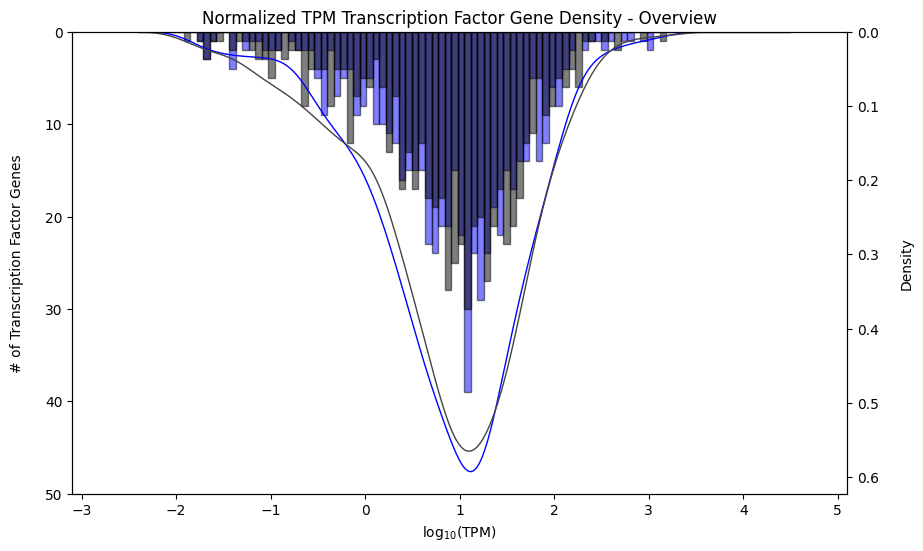

In [61]:
#NOTE: For mirrored histogram, I manually crop and append this plot to the previous plot.

#Data
data_l4 = np.log10(df_zero_filtered_tpm['L450 TPM'])
data_dauer = np.log10(df_zero_filtered_tpm['Dauer (D819) TPM'])
data_l4_tfs = np.log10(df_zero_filtered_tfs['L450 TPM'])
data_dauer_tfs = np.log10(df_zero_filtered_tfs['Dauer (D819) TPM'])

#Set bin edges for histogram
bin = np.linspace(min(data_l4.min(), data_dauer.min()), max(data_l4.max(), data_dauer.max()), 101)

#Figure specifications
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.hist(data_l4_tfs, color='blue', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1)
ax.hist(data_dauer_tfs, color='black', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1)
ax.set_xlabel('log$_{10}$(TPM)')
ax.set_ylabel('# of Transcription Factor Genes', labelpad=15, )
ax.set_xlim(-3.1, 5.1)
ax.set_ylim(0, 50)
#ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#ax.yaxis.set_major_locator(MultipleLocator(3))
ax.invert_yaxis()
ax.set_title('Normalized TPM Transcription Factor Gene Density - Overview')

# Kernal Density Estimate (KDE) on right y-axis
ax2 = ax.twinx()
sns.kdeplot(data_l4_tfs, color='blue', label='L4 KDE', bw_adjust=1, linewidth=1, ax=ax2, fill=False, alpha=1)
sns.kdeplot(data_dauer_tfs, color='#444444', label='Dauer KDE', bw_adjust=1, linewidth=1, ax=ax2, fill=False, alpha=1)
ax2.invert_yaxis()
ax2.set_ylabel('Density', labelpad=15)
plt.savefig('Figures/D819 vs L4/Figure 5: Part 2 - Mirrored TF histogram.png', dpi=300, bbox_inches='tight')

#### Exporting Transcription Factor Gene Lists

In [62]:
#Get correspondance between transcription factor gene and which bin it belongs to
bin_indices_l4 = np.digitize(data_l4_tfs, bin)
bin_indices_dauer = np.digitize(data_dauer_tfs, bin)

# Get gene names for each bin
bin_dict_l4={}
bin_dict_dauer={}
for i in range(1, len(bin)):
    genes_in_bin_for_l4 = df_zero_filtered_tfs['Name'][(bin_indices_l4 == i)].tolist()
    genes_in_bin_for_dauer = df_zero_filtered_tfs['Name'][(bin_indices_dauer == i)].tolist()
    bin_dict_l4[i] = genes_in_bin_for_l4
    bin_dict_dauer[i] = genes_in_bin_for_dauer

#Make Transcription Factor Gene Table
df_bins = pd.DataFrame({
    'L4_genes': pd.Series(bin_dict_l4),
    'Dauer_genes': pd.Series(bin_dict_dauer)
})

# Add bin range (in TPM) as a new column
df_bins['bin_range'] = [f"{10**bin[i-1]:.3f} - {10**bin[i]:.3f}" for i in df_bins.index]

# Set bin range as first column
df_bins = df_bins[['bin_range', 'L4_genes', 'Dauer_genes']]

# Filter out rows where both gene lists are empty
df_bins = df_bins[df_bins['L4_genes'].apply(lambda x: len(x) > 0) | df_bins['Dauer_genes'].apply(lambda x: len(x) > 0)]

df_bins.to_excel('Data/D819 vs L450/Transcription Factor Gene Densities.xlsx', index=False)

#### More Zoomed-In Figures

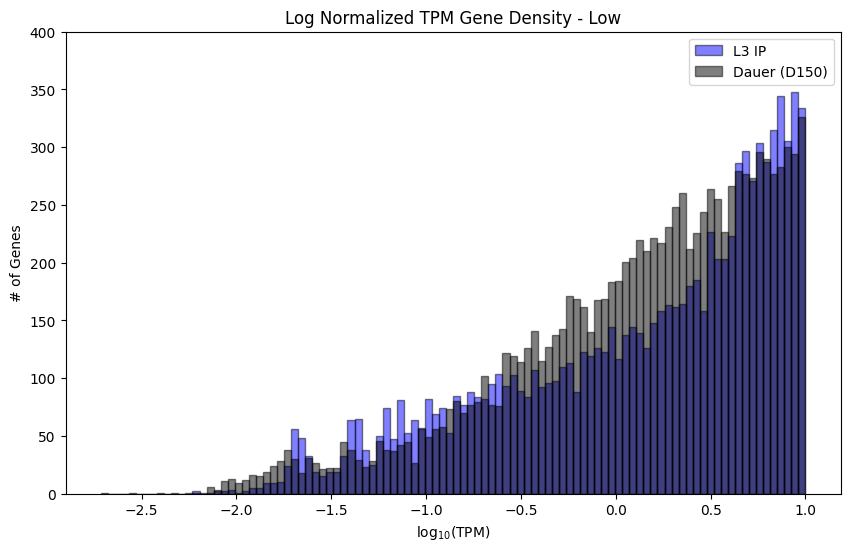

In [ ]:
#Data
data_l3 = np.log10(df_zero_filtered_tpm['L3 IP           TPM'])
data_dauer = np.log10(df_zero_filtered_tpm['Dauer (D150)   TPM'])

#Set bin edges for histogram
bin = np.linspace(min(data_l3.min(), data_dauer.min()), np.log10(10), 101)

#Figure specifications
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(data_l3, color='blue', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1)
n2, bins2, patches2 = plt.hist(data_dauer, color='black', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1)
plt.xlabel('log$_{10}$(TPM)')
plt.ylabel('# of Genes')
plt.ylim(0, 400)
plt.title('Log Normalized TPM Gene Density - Low')
plt.legend(['L3 IP', 'Dauer (D150)'])
#plt.savefig('TPM Gene Density Zero Filtered histogram.png', dpi=300, bbox_inches='tight')

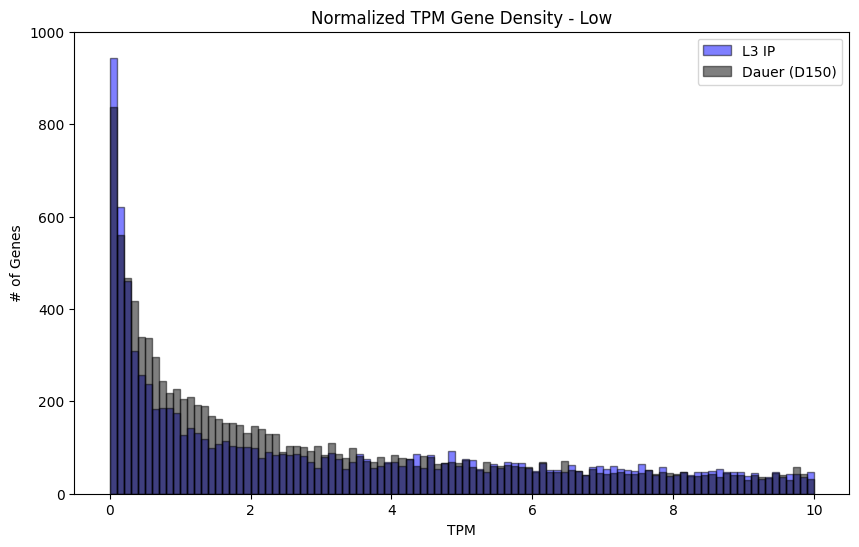

In [134]:
#Data
data_l3 = (df_zero_filtered_tpm['L3 IP           TPM'])
data_dauer = (df_zero_filtered_tpm['Dauer (D150)   TPM'])

#Set bin edges for histogram
bin = np.linspace(0, 10, 101)

#Figure specifications
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(data_l3, color='blue', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1)
n2, bins2, patches2 = plt.hist(data_dauer, color='black', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1)
plt.xlabel('TPM')
plt.ylabel('# of Genes')
plt.ylim(0, 1000)
plt.title('Normalized TPM Gene Density - Low')
plt.legend(['L3 IP', 'Dauer (D150)'])
#plt.savefig('TPM Gene Density Zero Filtered histogram.png', dpi=300, bbox_inches='tight')

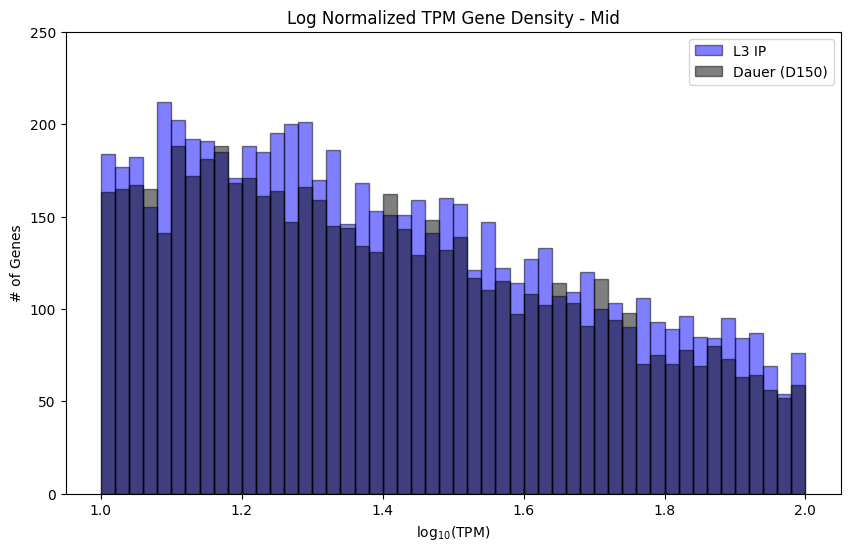

In [135]:
#Data
data_l3 = np.log10(df_zero_filtered_tpm['L3 IP           TPM'])
data_dauer = np.log10(df_zero_filtered_tpm['Dauer (D150)   TPM'])

#Set bin edges for histogram
bin = np.linspace(np.log10(10), np.log10(100), 51)

#Figure specifications
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(data_l3, color='blue', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1)
n2, bins2, patches2 = plt.hist(data_dauer, color='black', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1)
plt.xlabel('log$_{10}$(TPM)')
plt.ylabel('# of Genes')
plt.ylim(0, 250)
plt.title('Log Normalized TPM Gene Density - Mid')
plt.legend(['L3 IP', 'Dauer (D150)'])
#plt.savefig('TPM Gene Density Zero Filtered histogram.png', dpi=300, bbox_inches='tight')

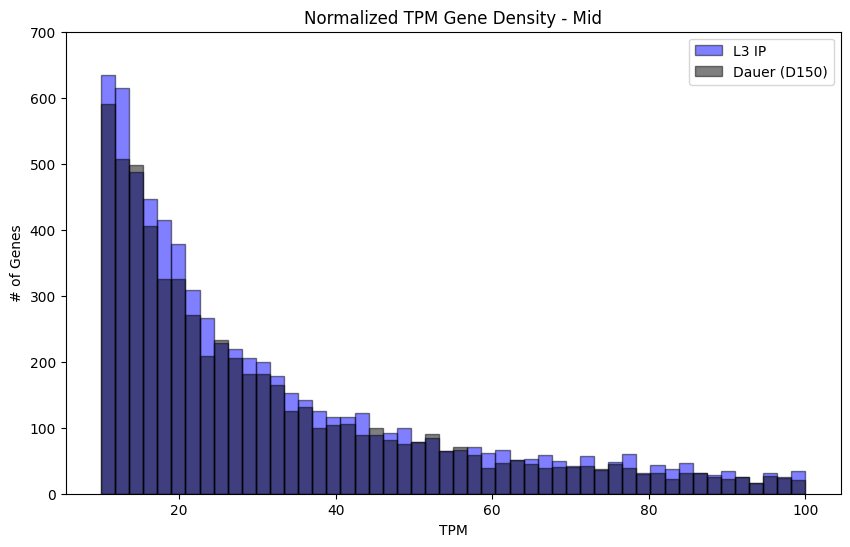

In [136]:
#Data
data_l3 = (df_zero_filtered_tpm['L3 IP           TPM'])
data_dauer = (df_zero_filtered_tpm['Dauer (D150)   TPM'])

#Set bin edges for histogram
bin = np.linspace(10, 100, 51)

#Figure specifications
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(data_l3, color='blue', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1)
n2, bins2, patches2 = plt.hist(data_dauer, color='black', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1)
plt.xlabel('TPM')
plt.ylabel('# of Genes')
plt.ylim(0, 700)
plt.title('Normalized TPM Gene Density - Mid')
plt.legend(['L3 IP', 'Dauer (D150)'])
#plt.savefig('TPM Gene Density Zero Filtered histogram.png', dpi=300, bbox_inches='tight')

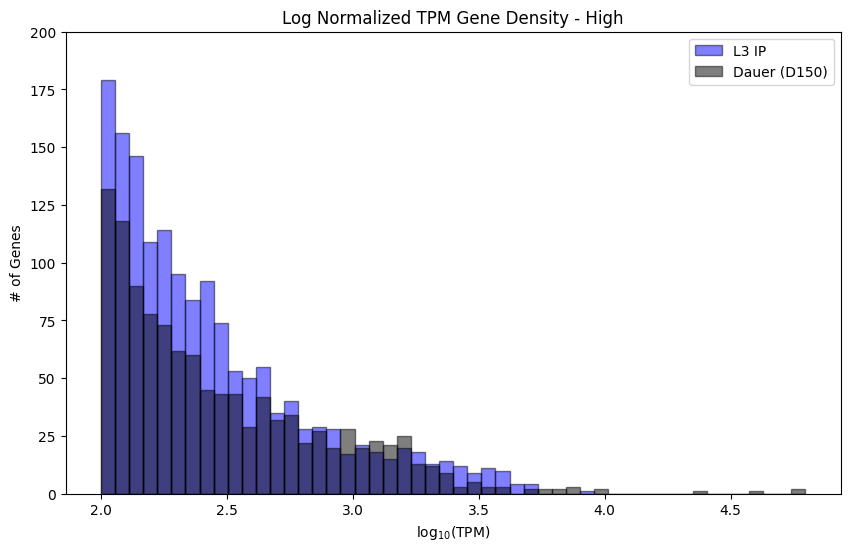

In [137]:
#Data
data_l3 = np.log10(df_zero_filtered_tpm['L3 IP           TPM'])
data_dauer = np.log10(df_zero_filtered_tpm['Dauer (D150)   TPM'])

#Set bin edges for histogram
bin = np.linspace(np.log10(100), max(data_l3.max(), data_dauer.max()), 51)

#Figure specifications
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(data_l3, color='blue', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1)
n2, bins2, patches2 = plt.hist(data_dauer, color='black', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1)
plt.xlabel('log$_{10}$(TPM)')
plt.ylabel('# of Genes')
plt.ylim(0, 200)
plt.title('Log Normalized TPM Gene Density - High')
plt.legend(['L3 IP', 'Dauer (D150)'])
#plt.savefig('TPM Gene Density Zero Filtered histogram.png', dpi=300, bbox_inches='tight')

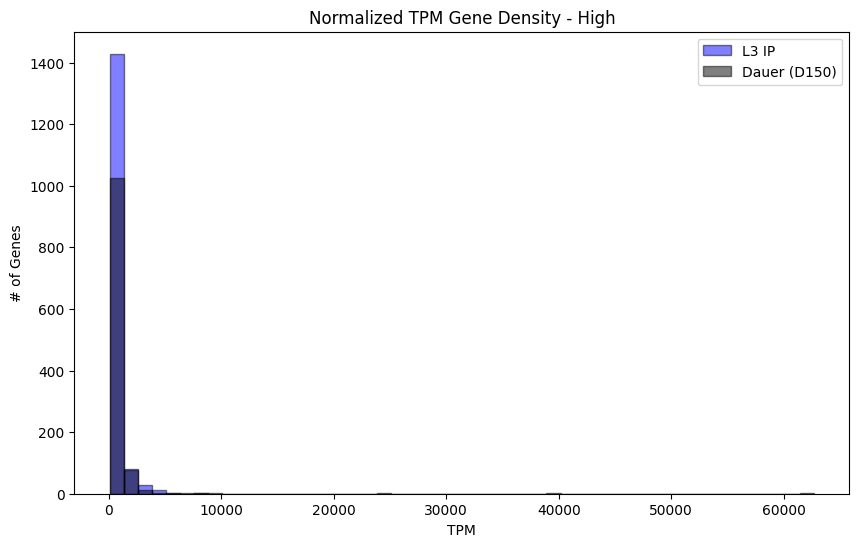

In [138]:
#Data
data_l3 = (df_zero_filtered_tpm['L3 IP           TPM'])
data_dauer = (df_zero_filtered_tpm['Dauer (D150)   TPM'])

#Set bin edges for histogram
bin = np.linspace(100, max(data_l3.max(), data_dauer.max()), 51)

#Figure specifications
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(data_l3, color='blue', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1)
n2, bins2, patches2 = plt.hist(data_dauer, color='black', bins=bin, alpha=0.5, density=False, edgecolor='black', linewidth=1)
plt.xlabel('TPM')
plt.ylabel('# of Genes')
plt.ylim(0, 1500)
plt.title('Normalized TPM Gene Density - High')
plt.legend(['L3 IP', 'Dauer (D150)'])
#plt.savefig('TPM Gene Density Zero Filtered histogram.png', dpi=300, bbox_inches='tight')

## Step 4: Statistical Analysis

1. Use Chi-Square Test of Homogeneity to compare distributions across worms
<br>
Null hypothesis: All 4 histograms are drawn from the same distribution
<br>
Post-hoc: Pairwise Chi-Square Tests with Bonferroni Correction
2. Use G-Test (Likelihood Ratio Test) to compare distributions for gene sets across worms due to low counts in bins
<br>
3. Alternatively, use Kolmogorov-Smirnov Test to compare distributions for continuous raw data and Kruskal–Wallis H-test to compare mean differences if mean is more relevant than distribution shape


In [ ]:
def contingency_from_series(series_dict, bins):
    """Return contingency matrix (groups x bins)."""
    #Create contingency matrix
    counts = [np.histogram(series_dict[worm], bins=bins)[0] for worm in series_dict.keys()] #Array of arrays of counts per worm
    cont_matrix = np.vstack(counts) #Array of lists where each list is the counts for a worm

    #Drop bins that are empty across all groups to avoid zero-expected frequency error in chi-square test
    col_sums = cont_matrix.sum(axis=0)
    nonempty_cols = col_sums > 0
    cont_matrix = cont_matrix[:, nonempty_cols]
    
    return cont_matrix

def chi_square_homogeneity(contingency):
    """Chi-square test of homogeneity (no Yates correction)."""
    chi2_stat, p, dof, expected = chi2_contingency(contingency, correction=False)
    return {"chi2": chi2_stat, "p": p, "dof": dof, "expected": expected}

def g_test(contingency):
    """G-test (likelihood ratio) for contingency table. Returns G, p and df."""
    O = contingency.astype(float)
    row_sums = O.sum(axis=1, keepdims=True)
    col_sums = O.sum(axis=0, keepdims=True)
    total = O.sum()
    E = (row_sums @ col_sums) / total
    mask = O > 0
    G = 2.0 * np.sum(O[mask] * np.log(O[mask] / E[mask]))
    df = (O.shape[0] - 1) * (O.shape[1] - 1)
    p = float(chi2.sf(G, df))
    return {"G": G, "p": p, "dof": df, "expected": E}

def pairwise_tests(series_dict, bins, alpha=0.05, method='chi2'):
    """
    Pairwise tests between groups.
    method: 'chi2' or 'g'
    Returns DataFrame with raw and Bonferroni-adjusted p-values.
    """
    names = list(series_dict.keys())
    pairs = list(itertools.combinations(range(len(names)), 2))
    results = []
    m = len(pairs)
    for i, j in pairs:
        cont = np.vstack([
            np.histogram(series_dict[names[i]], bins=bins)[0],
            np.histogram(series_dict[names[j]], bins=bins)[0]
        ])
        col_sums = cont.sum(axis=0)
        nonempty_cols = col_sums > 0
        cont = cont[:, nonempty_cols]
        if method == 'chi2':
            stat, p, _, _ = chi2_contingency(cont, correction=False)
            stat_name = 'chi2'
        else:
            gt = g_test(cont)
            stat, p = gt['G'], gt['p']
            stat_name = 'G'
        p_adj = min(p * m, 1.0)  # Bonferroni
        results.append({
            "group1": names[i], "group2": names[j],
            stat_name: stat, "p_raw": p, "p_bonf": p_adj
        })
    return pd.DataFrame(results)

In [66]:
def compare_distributions(worm_df, method='chi2'):
    """Compare distributions using chi-square and G-test."""
    #Take log10 and convert to dictionary
    worm_cols = worm_df.filter(regex=r'^(L|D).*TPM').columns
    worm_df_log = np.log10(worm_df[worm_cols])
    worm_dict = {col: worm_df_log[col].values for col in worm_cols}
    
    #Create bins
    bins = np.linspace(min(i.min() for i in worm_dict.values()), max(i.max() for i in worm_dict.values()), 101)
    
    #Get contingency matrix
    cont = contingency_from_series(worm_dict, bins)
    
    #Compare distributions for all genes
    if method == 'chi2':
        overall_result = chi_square_homogeneity(cont)
    else:
        overall_result = g_test(cont)
    
    #Post-hoc pairwise tests    
    pairwise_result = pairwise_tests(worm_dict, bins, method=method)
    
    return overall_result, pairwise_result

In [81]:
r1, r1_pair = compare_distributions(df_zero_filtered_tpm, method='chi2')
print("OVERALL")
print(f"chi2: {r1['chi2']:.2f}\np: {r1['p']:.2e}\ndof: {r1['dof']}\n")
print("PAIRWISE:\n", r1_pair)

OVERALL
chi2: 1268.51
p: 6.64e-124
dof: 285

PAIRWISE:
      group1    group2        chi2         p_raw        p_bonf
0  L450 TPM  D819 TPM  422.504733  3.630609e-44  2.178365e-43
1  L450 TPM  L300 TPM  397.777696  1.318015e-41  7.908090e-41
2  L450 TPM  D150 TPM  385.833427  6.016177e-38  3.609706e-37
3  D819 TPM  L300 TPM  417.456939  5.641015e-44  3.384609e-43
4  D819 TPM  D150 TPM  288.132260  1.416385e-21  8.498307e-21
5  L300 TPM  D150 TPM  543.210275  6.143987e-66  3.686392e-65


In [69]:
compare_distributions(df_zero_filtered_neuropep, method='g')

({'G': 303.8851095202055,
  'p': 0.004804730273912882,
  'df': 243,
  'expected': array([[0.25, 0.5 , 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5 , 0.25, 1.  ,
          0.5 , 0.75, 0.25, 0.25, 0.5 , 1.  , 1.  , 0.25, 0.75, 1.75, 0.25,
          1.25, 0.75, 0.75, 1.  , 0.75, 1.25, 0.5 , 0.25, 1.  , 1.25, 1.75,
          0.5 , 0.5 , 0.5 , 1.75, 0.5 , 1.25, 1.  , 2.75, 1.25, 1.  , 0.75,
          3.25, 2.75, 2.25, 2.75, 2.25, 2.25, 3.  , 3.  , 1.5 , 2.5 , 3.  ,
          3.5 , 3.5 , 2.75, 4.25, 1.5 , 4.  , 2.75, 4.  , 3.  , 3.5 , 3.75,
          1.25, 1.75, 1.5 , 1.75, 1.5 , 1.25, 1.  , 1.  , 0.5 , 1.  , 0.5 ,
          0.25, 0.5 , 1.25, 0.25, 0.25],
         [0.25, 0.5 , 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5 , 0.25, 1.  ,
          0.5 , 0.75, 0.25, 0.25, 0.5 , 1.  , 1.  , 0.25, 0.75, 1.75, 0.25,
          1.25, 0.75, 0.75, 1.  , 0.75, 1.25, 0.5 , 0.25, 1.  , 1.25, 1.75,
          0.5 , 0.5 , 0.5 , 1.75, 0.5 , 1.25, 1.  , 2.75, 1.25, 1.  , 0.75,
          3.25, 2.75, 2.25, 2.75, 2.25, 2.2

In [63]:
compare_distributions(df_zero_filtered_gpcrs, method='g')

({'G': 491.78909882174446,
  'p': 0.0,
  'df': 255,
  'expected': array([[0.25, 0.75, 0.25, 0.25, 0.25, 0.75, 0.5 , 0.5 , 0.5 , 0.25, 0.25,
          0.25, 0.75, 0.5 , 1.25, 0.25, 0.5 , 0.75, 0.25, 0.5 , 0.5 , 0.25,
          0.75, 0.75, 0.75, 0.5 , 1.  , 1.  , 0.5 , 0.75, 0.5 , 0.75, 0.75,
          1.75, 1.  , 1.5 , 2.  , 0.25, 0.75, 2.75, 1.5 , 1.  , 2.  , 0.75,
          3.25, 3.  , 1.75, 1.5 , 2.5 , 2.5 , 1.5 , 1.25, 1.5 , 1.75, 3.75,
          1.5 , 1.25, 2.75, 1.5 , 4.  , 4.5 , 3.  , 5.25, 4.25, 3.25, 4.25,
          3.  , 3.  , 3.5 , 4.75, 2.75, 2.5 , 2.75, 1.75, 3.25, 1.75, 0.75,
          0.75, 1.  , 1.  , 1.5 , 0.5 , 1.  , 0.75, 0.25, 0.25],
         [0.25, 0.75, 0.25, 0.25, 0.25, 0.75, 0.5 , 0.5 , 0.5 , 0.25, 0.25,
          0.25, 0.75, 0.5 , 1.25, 0.25, 0.5 , 0.75, 0.25, 0.5 , 0.5 , 0.25,
          0.75, 0.75, 0.75, 0.5 , 1.  , 1.  , 0.5 , 0.75, 0.5 , 0.75, 0.75,
          1.75, 1.  , 1.5 , 2.  , 0.25, 0.75, 2.75, 1.5 , 1.  , 2.  , 0.75,
          3.25, 3.  , 1.75, 1.5 , 2

In [70]:
compare_distributions(df_zero_filtered_ion_channels, method='g')

({'G': 378.1832731430641,
  'p': 3.003563969241313e-08,
  'df': 240,
  'expected': array([[ 0.25,  0.25,  0.25,  0.25,  0.25,  0.25,  0.25,  0.75,  0.75,
           0.5 ,  0.5 ,  0.25,  0.5 ,  0.75,  1.  ,  0.75,  1.75,  1.5 ,
           1.  ,  1.75,  1.  ,  2.5 ,  2.75,  3.5 ,  3.25,  4.5 ,  2.75,
           5.5 ,  5.5 ,  6.75,  4.5 ,  6.75,  6.75,  7.5 , 10.  ,  6.  ,
           8.5 ,  8.75,  8.75,  7.25, 11.  , 10.5 ,  9.75, 10.25, 15.  ,
          15.  , 14.  , 17.  , 19.75, 19.5 , 20.  , 17.5 , 15.5 , 14.25,
          16.25, 11.  ,  9.25, 15.  , 14.  , 12.75,  7.5 ,  7.5 ,  7.  ,
           5.5 ,  6.5 ,  3.  ,  3.  ,  2.  ,  1.75,  1.75,  2.25,  1.25,
           1.25,  0.5 ,  0.5 ,  0.5 ,  0.25,  0.5 ,  0.5 ,  0.25,  0.25],
         [ 0.25,  0.25,  0.25,  0.25,  0.25,  0.25,  0.25,  0.75,  0.75,
           0.5 ,  0.5 ,  0.25,  0.5 ,  0.75,  1.  ,  0.75,  1.75,  1.5 ,
           1.  ,  1.75,  1.  ,  2.5 ,  2.75,  3.5 ,  3.25,  4.5 ,  2.75,
           5.5 ,  5.5 ,  6.75,  4.5 ,  6.7

In [71]:
compare_distributions(df_zero_filtered_tfs, method='g')

({'G': 387.28326614656066,
  'p': 3.237772589742304e-07,
  'df': 258,
  'expected': array([[ 0.25,  0.25,  0.25,  1.  ,  1.  ,  0.75,  1.75,  0.5 ,  0.5 ,
           0.5 ,  0.75,  0.75,  0.25,  1.25,  1.25,  1.  ,  1.  ,  2.  ,
           1.25,  0.25,  1.25,  0.5 ,  3.25,  3.5 ,  4.75,  3.5 ,  4.  ,
           4.25,  3.5 ,  3.25,  5.  ,  3.75,  6.  ,  6.25,  6.  ,  4.75,
           7.25,  6.  , 10.25,  7.25, 11.5 , 12.5 , 12.5 , 14.5 , 14.  ,
          11.75, 19.  , 17.25, 17.  , 23.75, 23.  , 22.25, 21.75, 25.75,
          19.5 , 22.5 , 20.25, 19.  , 17.5 , 13.5 , 11.5 , 12.25, 10.25,
           9.5 ,  7.75,  6.25,  5.  ,  7.5 ,  4.5 ,  3.25,  4.5 ,  1.75,
           3.  ,  2.25,  1.5 ,  1.5 ,  0.5 ,  1.  ,  0.5 ,  1.  ,  0.75,
           0.5 ,  0.5 ,  0.5 ,  0.25,  0.5 ,  0.25],
         [ 0.25,  0.25,  0.25,  1.  ,  1.  ,  0.75,  1.75,  0.5 ,  0.5 ,
           0.5 ,  0.75,  0.75,  0.25,  1.25,  1.25,  1.  ,  1.  ,  2.  ,
           1.25,  0.25,  1.25,  0.5 ,  3.25,  3.5 ,  4.75,  3.

In [72]:
compare_distributions(df_zero_filtered_gap_junctions, method='g')

({'G': 153.65892494595386,
  'p': 0.22011489121776534,
  'df': 141,
  'expected': array([[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5 , 1.5 ,
          0.5 , 0.5 , 0.25, 0.25, 0.75, 0.5 , 0.5 , 0.5 , 0.5 , 0.75, 0.5 ,
          0.25, 0.5 , 0.75, 0.25, 0.5 , 0.5 , 0.25, 1.  , 0.75, 0.25, 0.75,
          1.25, 0.75, 0.5 , 0.25, 0.75, 0.25, 0.75, 0.5 , 0.25, 0.25, 0.5 ,
          0.25, 0.25, 0.25, 0.25],
         [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5 , 1.5 ,
          0.5 , 0.5 , 0.25, 0.25, 0.75, 0.5 , 0.5 , 0.5 , 0.5 , 0.75, 0.5 ,
          0.25, 0.5 , 0.75, 0.25, 0.5 , 0.5 , 0.25, 1.  , 0.75, 0.25, 0.75,
          1.25, 0.75, 0.5 , 0.25, 0.75, 0.25, 0.75, 0.5 , 0.25, 0.25, 0.5 ,
          0.25, 0.25, 0.25, 0.25],
         [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5 , 1.5 ,
          0.5 , 0.5 , 0.25, 0.25, 0.75, 0.5 , 0.5 , 0.5 , 0.5 , 0.75, 0.5 ,
          0.25, 0.5 , 0.75, 0.25, 0.5 , 0.5 , 0.25, 1.  , 0.75, 0.25, 0.75,
          1.25